In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sys

In [2]:
from pathlib import Path
sys.path.insert(0,os.path.abspath('../'))
sys.path.insert(0,os.path.abspath('../utilities'))

In [3]:
import timm

In [4]:
from utilities.utils import *

## ViT on ImageNet

In [5]:
SEED=566
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

In [6]:
model = timm.create_model('vit_large_patch32_224_in21k',pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_patch32_224_in21k-9046d2e7.pth" to /home/abc586/.cache/torch/hub/checkpoints/jx_vit_large_patch32_224_in21k-9046d2e7.pth


In [7]:
LABEL='ViT-ImageNet'
TYPE="PRETRAINED"

## Getting the hooks for each layers

In [8]:
hookLayersActivationDict = {}
activationDict = {}

In [9]:
modelNamedModules = dict(model.named_modules())

In [10]:
hookLayers = []

for i in modelNamedModules.keys():
    if i.__contains__("norm") or \
        i.__contains__("qkv") or \
        i.__contains__("act") or \
        i.__contains__("proj") or \
        i.__contains__("fc") or \
        i.__contains__("drop_path") :
        hookLayers.append(i)

In [11]:
for layer in hookLayers:
    h = model.get_submodule(layer).register_forward_hook(getActivation(layer,hookLayersActivationDict))

## ImageNet

In [12]:
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
NUM_WORKERS = 0

# normalize = transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
#                                      std=[0.2675, 0.2565, 0.2761])

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# #train_dataset = datasets.CIFAR100(root='./data', train=True, transform=transforms.Compose([
#             transforms.RandomHorizontalFlip(),
#             transforms.RandomCrop(32, 4),
#             transforms.ToTensor(),
#             normalize,
#         ]), download=True)

# train_loader = torch.utils.data.DataLoader(train_dataset,
#         batch_size=TRAIN_BATCH_SIZE, shuffle=True,
#         num_workers=NUM_WORKERS, pin_memory=True)

# val_loader = torch.utils.data.DataLoader(
#         datasets.CIFAR100(root='./data', train=False, transform=transforms.Compose([
#             transforms.ToTensor(),
#             normalize,
#         ])),
#         batch_size=TEST_BATCH_SIZE, shuffle=False,
#         num_workers=NUM_WORKERS, pin_memory=True)

#valdir = os.path.join(args.data, 'val')
valdir = '/home/abc586/dataset/imagenet/val'
val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=TEST_BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=True)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
model = model.to(device)
valid_acc,activationDict = evaluate(model,device,val_loader,hookLayers,hookLayersActivationDict)

Iteration:   0%|          | 0/782 [00:01<?, ?it/s]


## HSIC calculation and plots

In [15]:
col1,col2,hsicScoreList = getLayerWiseOutputCorrelation(hookLayers,hookLayers,activationDict,activationDict)

Layer 1:patch_embed.proj, HSIC score:0.059728462249040604
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.2680576724046875e-31
Denom:0.0
Layer 1:patch_embed.proj, HSIC score:0.059728462249040604
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:8.9250757420032e-35
Denom:0.0
Layer 1:patch_embed.proj, HSIC score:0.059728462249040604
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.6533612294906365e-37
Denom:0.0
Layer 1:patch_embed.proj, HSIC score:0.059728462249040604
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.771186767585744e-35
Denom:0.0
Layer 1:patch_embed.proj, HSIC score:0.059728462249040604
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.5086672860697409e-33
Denom:0.0
Layer 1:patch_embed.proj, HSIC score:0.059728462249040604
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.0771918780777583e-36
Denom:0.0
Layer 1:patch_embed.proj, HSIC score:0.059728462249040604
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC 

Layer 1:blocks.0.norm1, HSIC score:0.015402977354824543
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.8094990690516293e-31
Denom:0.0
Layer 1:blocks.0.norm1, HSIC score:0.015402977354824543
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cross HSIC score:7.755506732187396e-34
Denom:0.0
Layer 1:blocks.0.norm1, HSIC score:0.015402977354824543
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:5.4763108323414576e-39
Denom:0.0
Layer 1:blocks.0.norm1, HSIC score:0.015402977354824543
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.969777225332109e-40
Denom:0.0
Layer 1:blocks.0.norm1, HSIC score:0.015402977354824543
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.5223372357846707e-44
Denom:0.0
Layer 1:blocks.0.norm1, HSIC score:0.015402977354824543
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.942726775082116e-43
Denom:0.0
Layer 1:blocks.0.norm1, HSIC score:0.015402977354824543
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf


Layer 1:blocks.0.attn.proj, HSIC score:0.3729797601699829
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.0.attn.proj, HSIC score:0.3729797601699829
Layer 1:blocks.13.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.0.attn.proj, HSIC score:0.3729797601699829
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.0.attn.proj, HSIC score:0.3729797601699829
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.0.attn.proj, HSIC score:0.3729797601699829
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.0.attn.proj, HSIC score:0.3729797601699829
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.0.attn.proj, HSIC score:0.3729797601699829
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.0.attn.proj, HSIC score:0.3729797601699829
Layer 1:blocks.19.mlp.fc1

Layer 1:blocks.0.drop_path, HSIC score:9.9443037470337e-05
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.0.drop_path, HSIC score:9.9443037470337e-05
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.0.drop_path, HSIC score:9.9443037470337e-05
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.0.drop_path, HSIC score:9.9443037470337e-05
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.0.drop_path, HSIC score:9.9443037470337e-05
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.0.drop_path, HSIC score:9.9443037470337e-05
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.0.norm2, HSIC score:0.013878085650503635
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:7.675179903185555e-29
Denom:0.0
Layer 1:blocks.0.norm2, HSIC score:0.013878085650503635
Laye

Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.attn.proj_drop, HSIC score:0.0038203296717256308
Cross HSIC score:3.4465674922041756e-29
Denom:0.0
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.drop_path, HSIC score:0.0037526304367929697
Cross HSIC score:5.173157367889703e-29
Denom:0.0
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.norm2, HSIC score:0.013614203780889511
Cross HSIC score:7.674578050077934e-29
Denom:0.0
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.mlp.act, HSIC score:0.0026661052834242582
Cross HSIC score:3.553253478693845e-29
Denom:0.0
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.mlp.fc2, HSIC score:0.0037526304367929697
Cross HSIC score:5.173157367889703e-29
Denom:0.0
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Layer 1:blocks.7.norm1, HSIC score:0.014479272067546844
Cross HSIC score:7.942087311940891e-29

Denom:0.0
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Layer 1:blocks.14.norm2, HSIC score:0.01120203547179699
Cross HSIC score:7.146293058920085e-29
Denom:0.0
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Layer 1:blocks.14.mlp.act, HSIC score:0.0026170487981289625
Cross HSIC score:3.1828369650774175e-29
Denom:0.0
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Layer 1:blocks.14.mlp.fc2, HSIC score:11790.7255859375
Cross HSIC score:1.9179747703813229e-28
Denom:0.0
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Layer 1:blocks.15.norm1, HSIC score:0.013500571250915527
Cross HSIC score:7.942458053455185e-29
Denom:0.0
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Layer 1:blocks.15.attn.qkv, HSIC score:4.410256881914876e-13
Cross HSIC score:1.8935834163417278e-34
Denom:0.0
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Layer 1:blocks.15.attn.proj, HSIC score:0.0033916353713721037
Cross HSIC score:3.172945810180

Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.attn.qkv, HSIC score:6.674696138570548e-19
Cross HSIC score:9.720819778447742e-38
Denom:0.0
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.attn.proj, HSIC score:0.0011618202552199364
Cross HSIC score:1.8801808327278092e-29
Denom:0.0
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.attn.proj_drop, HSIC score:0.0011618202552199364
Cross HSIC score:1.8801808327278092e-29
Denom:0.0
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.drop_path, HSIC score:0.9387885332107544
Cross HSIC score:2.956178482894237e-29
Denom:0.0
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.norm2, HSIC score:0.0009651080472394824
Cross HSIC score:3.974001162141295e-29
Denom:0.0
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.mlp.act, HSIC score:0.011684855446219444
Cross HSIC score:9.61979257

Layer 1:blocks.0.mlp.fc2, HSIC score:9.9443037470337e-05
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.272676509566597e-34
Denom:0.0
Layer 1:blocks.0.mlp.fc2, HSIC score:9.9443037470337e-05
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.459447060080507e-32
Denom:0.0
Layer 1:blocks.0.mlp.fc2, HSIC score:9.9443037470337e-05
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.99881953740301e-35
Denom:0.0
Layer 1:blocks.0.mlp.fc2, HSIC score:9.9443037470337e-05
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.2719165771137067e-40
Denom:0.0
Layer 1:blocks.0.mlp.fc2, HSIC score:9.9443037470337e-05
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:7.604846765890782e-42
Denom:0.0
Layer 1:blocks.0.mlp.fc2, HSIC score:9.9443037470337e-05
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.401298464324817e-45
Denom:0.0
Layer 1:blocks.0.mlp.fc2, HSIC score:9.9443037470337e-05
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.4

Layer 1:blocks.1.attn.qkv, HSIC score:1.2183180896421786e-12
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.802596928649634e-45
Denom:0.0
Layer 1:blocks.1.attn.qkv, HSIC score:1.2183180896421786e-12
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.1.attn.qkv, HSIC score:1.2183180896421786e-12
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.1.attn.qkv, HSIC score:1.2183180896421786e-12
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.1.attn.qkv, HSIC score:1.2183180896421786e-12
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.1.attn.qkv, HSIC score:1.2183180896421786e-12
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.1.attn.qkv, HSIC score:1.2183180896421786e-12
Layer 1:blocks.11.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.1.attn.qkv, HSIC score:1.218

Layer 1:blocks.1.attn.proj_drop, HSIC score:0.003094483632594347
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:7.121118536005855e-41
Denom:0.0
Layer 1:blocks.1.attn.proj_drop, HSIC score:0.003094483632594347
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:8.407790785948902e-45
Denom:0.0
Layer 1:blocks.1.attn.proj_drop, HSIC score:0.003094483632594347
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.2891945871788317e-43
Denom:0.0
Layer 1:blocks.1.attn.proj_drop, HSIC score:0.003094483632594347
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.1.attn.proj_drop, HSIC score:0.003094483632594347
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.1.attn.proj_drop, HSIC score:0.003094483632594347
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.1.attn.proj_drop, HSIC score:0.003094483632594347
Layer 1:blocks.11.drop_path, HSIC score:nan
Cross HSI

Layer 1:blocks.1.norm2, HSIC score:0.018530307337641716
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.1.norm2, HSIC score:0.018530307337641716
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.1.norm2, HSIC score:0.018530307337641716
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.1.norm2, HSIC score:0.018530307337641716
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.1.norm2, HSIC score:0.018530307337641716
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.1.norm2, HSIC score:0.018530307337641716
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.1.norm2, HSIC score:0.018530307337641716
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.1.norm2, HSIC score:0.018530307337641716
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0

Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.norm2, HSIC score:0.012643419206142426
Cross HSIC score:1.9318409177303457e-32
Denom:0.0
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.mlp.act, HSIC score:0.0022152988240122795
Cross HSIC score:9.363518535593983e-33
Denom:0.0
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.mlp.fc2, HSIC score:5.806411266326904
Cross HSIC score:1.888162927200048e-32
Denom:0.0
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.norm1, HSIC score:0.014524969272315502
Cross HSIC score:2.1732076707101815e-32
Denom:0.0
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.attn.qkv, HSIC score:8.517750393899348e-10
Cross HSIC score:4.5096466106713945e-36
Denom:0.0
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.attn.proj, HSIC score:0.004965792875736952
Cross HSIC score:1.1916672429112821e-32
Denom:0

Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.mlp.act, HSIC score:0.0038238796405494213
Cross HSIC score:9.580325978975676e-33
Denom:0.0
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.mlp.fc2, HSIC score:0.020946521311998367
Cross HSIC score:5.629770482480211e-33
Denom:0.0
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Layer 1:blocks.17.norm1, HSIC score:0.012933398596942425
Cross HSIC score:2.025973035976256e-32
Denom:0.0
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Layer 1:blocks.17.attn.qkv, HSIC score:7.525586870251594e-14
Cross HSIC score:8.619465326775952e-39
Denom:0.0
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Layer 1:blocks.17.attn.proj, HSIC score:0.0029398712795227766
Cross HSIC score:9.066152994982499e-33
Denom:0.0
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Layer 1:blocks.17.attn.proj_drop, HSIC score:0.0029398712795227766
Cross HSIC score:9.066152994982499e-33
Denom:0.0
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Layer 1:blocks.17.drop_path, HSIC score:0.01487318519

Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.mlp.act, HSIC score:4.651518611353822e-05
Cross HSIC score:9.649458638457458e-35
Denom:0.0
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Layer 1:norm, HSIC score:0.015153431333601475
Cross HSIC score:2.2460892020819265e-32
Denom:0.0
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Layer 1:pre_logits.fc, HSIC score:0.015901733189821243
Cross HSIC score:2.2897889392577143e-32
Denom:0.0
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Layer 1:pre_logits.act, HSIC score:0.015847468748688698
Cross HSIC score:2.2689468366704597e-32
Denom:0.0
Layer 1:blocks.1.mlp.act, HSIC score:0.0007979790098033845
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.2276773474338212e-29
Denom:0.0
Layer 1:blocks.1.mlp.act, HSIC score:0.000

Layer 1:blocks.1.mlp.fc2, HSIC score:0.0004915724857710302
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.1.mlp.fc2, HSIC score:0.0004915724857710302
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.1.mlp.fc2, HSIC score:0.0004915724857710302
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.2.norm1, HSIC score:0.015230543911457062
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:8.172235940295165e-29
Denom:0.0
Layer 1:blocks.2.norm1, HSIC score:0.015230543911457062
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.2376588504714167e-32
Denom:0.0
Layer 1:blocks.2.norm1, HSIC score:0.015230543911457062
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Cross HSIC score:4.125254505219922e-35
Denom:0.0
Layer 1:blocks.2.norm1, HSIC score:0.015230543911457062
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.31682592081603e-33
Denom:0.0
Layer 1:blocks.2.n

Layer 1:blocks.2.attn.proj, HSIC score:0.0027267879340797663
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.747273449972757e-39
Denom:0.0
Layer 1:blocks.2.attn.proj, HSIC score:0.0027267879340797663
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:4.0091149064333016e-41
Denom:0.0
Layer 1:blocks.2.attn.proj, HSIC score:0.0027267879340797663
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:7.006492321624085e-45
Denom:0.0
Layer 1:blocks.2.attn.proj, HSIC score:0.0027267879340797663
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.9337918807682476e-43
Denom:0.0
Layer 1:blocks.2.attn.proj, HSIC score:0.0027267879340797663
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.2.attn.proj, HSIC score:0.0027267879340797663
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.2.attn.proj, HSIC score:0.0027267879340797663
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Cross HSIC score:inf


Layer 1:blocks.2.drop_path, HSIC score:0.0011627263156697154
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.2.drop_path, HSIC score:0.0011627263156697154
Layer 1:blocks.13.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.2.drop_path, HSIC score:0.0011627263156697154
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.2.drop_path, HSIC score:0.0011627263156697154
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.2.drop_path, HSIC score:0.0011627263156697154
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.2.drop_path, HSIC score:0.0011627263156697154
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.2.drop_path, HSIC score:0.0011627263156697154
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.2.drop_path, HSIC score:0.0011627263156697154
L

Layer 1:blocks.2.attn.qkv, HSIC score:3.204645437904219e-10
Cross HSIC score:4.823538363511171e-39
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.attn.proj, HSIC score:0.0027267879340797663
Cross HSIC score:2.456362471851807e-35
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.attn.proj_drop, HSIC score:0.0027267879340797663
Cross HSIC score:2.456362471851807e-35
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.drop_path, HSIC score:0.0011627263156697154
Cross HSIC score:3.940196940404917e-36
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.norm2, HSIC score:0.01745392568409443
Cross HSIC score:2.28293214180818e-35
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.mlp.act, HSIC score:0.0012429781490936875
Cross HSIC score:6.310039182424802e-36
Denom:0.0
Layer 1:blocks.2.mlp.fc1, H

Layer 1:blocks.8.mlp.fc2, HSIC score:5.806411266326904
Cross HSIC score:7.833759385381917e-36
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.norm1, HSIC score:0.014524969272315502
Cross HSIC score:4.00583736573458e-35
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.attn.qkv, HSIC score:8.517750393899348e-10
Cross HSIC score:1.7314561534268443e-38
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.attn.proj, HSIC score:0.004965792875736952
Cross HSIC score:2.5001002748407524e-35
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.attn.proj_drop, HSIC score:0.004965792875736952
Cross HSIC score:2.5001002748407524e-35
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.norm2, HSIC score:0.012786504812538624
Cross HSIC score:3.733374076014542e-35
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC sco

Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.15.mlp.act, HSIC score:0.0030054852832108736
Cross HSIC score:1.47204207338161e-35
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.15.mlp.fc2, HSIC score:0.005614584777504206
Cross HSIC score:1.739443361854827e-35
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.norm1, HSIC score:0.013046490028500557
Cross HSIC score:3.777005407225129e-35
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.attn.qkv, HSIC score:1.5942686081883706e-13
Cross HSIC score:1.6949966094626555e-40
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.attn.proj, HSIC score:0.0032725336495786905
Cross HSIC score:2.766223758480709e-35
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.attn.proj_drop, HSIC score:0.0032725336495786905
Cross HSIC score:2.766223758480709e-35
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.drop_path, HSIC score:0.0209465213

Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.mlp.act, HSIC score:0.07665564864873886
Cross HSIC score:8.37640241781284e-36
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.mlp.fc2, HSIC score:3.7741625732493885e+21
Cross HSIC score:4.115703354840581e-26
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.norm1, HSIC score:0.008220655843615532
Cross HSIC score:2.82395040342192e-35
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.attn.qkv, HSIC score:2.9097140970282673e-31
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.attn.proj, HSIC score:7.38701181733546e+32
Cross HSIC score:1.838226673170401e-20
Denom:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.attn.proj_drop, HSIC score:7.38701181733546e+32
Cross HSIC score:1.838226673170401e-20
D

Layer 1:blocks.2.mlp.fc2, HSIC score:0.0011627263156697154
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.2.mlp.fc2, HSIC score:0.0011627263156697154
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.2.mlp.fc2, HSIC score:0.0011627263156697154
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.2.mlp.fc2, HSIC score:0.0011627263156697154
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.2.mlp.fc2, HSIC score:0.0011627263156697154
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.2.mlp.fc2, HSIC score:0.0011627263156697154
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.2.mlp.fc2, HSIC score:0.0011627263156697154
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.2.mlp.fc2, HSIC score:0.0011627263156697154
Layer 1:blocks.21

Layer 1:blocks.3.attn.qkv, HSIC score:2.0082496863388366e-12
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.3.attn.qkv, HSIC score:2.0082496863388366e-12
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.3.attn.qkv, HSIC score:2.0082496863388366e-12
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.3.attn.qkv, HSIC score:2.0082496863388366e-12
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.3.attn.qkv, HSIC score:2.0082496863388366e-12
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.3.attn.qkv, HSIC score:2.0082496863388366e-12
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.3.attn.qkv, HSIC score:2.0082496863388366e-12
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.3.attn.proj, HSIC score:0.0019265618175268173

Layer 1:blocks.3.attn.proj_drop, HSIC score:0.0019265618175268173
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.3.drop_path, HSIC score:0.0022248129826039076
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.8205462175591813e-29
Denom:0.0
Layer 1:blocks.3.drop_path, HSIC score:0.0022248129826039076
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:4.9106192016944595e-33
Denom:0.0
Layer 1:blocks.3.drop_path, HSIC score:0.0022248129826039076
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.7508857776901873e-35
Denom:0.0
Layer 1:blocks.3.drop_path, HSIC score:0.0022248129826039076
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Cross HSIC score:5.419038140840361e-34
Denom:0.0
Layer 1:blocks.3.drop_path, HSIC score:0.0022248129826039076
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Cross HSIC score:6.226429007096542e-32
Denom:0.0
Layer 1:blocks.3.drop_path, HSIC score:0.0022248129826039076
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
C

Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.mlp.act, HSIC score:0.0012429781490936875
Cross HSIC score:5.19999762553409e-34
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.mlp.fc2, HSIC score:0.0011627263156697154
Cross HSIC score:6.140415146710998e-34
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.norm1, HSIC score:0.015058547258377075
Cross HSIC score:3.187640928370584e-33
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.attn.qkv, HSIC score:2.0082496863388366e-12
Cross HSIC score:9.592920465011887e-38
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.attn.proj, HSIC score:0.0019265618175268173
Cross HSIC score:1.0082463921197348e-33
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.attn.proj_drop, HSIC score:0.0019265618175268173
Cross HSIC score:1.0082463921197348e-33
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.drop_path, HSIC score:0.002224812982603

Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.mlp.act, HSIC score:0.0021738368086516857
Cross HSIC score:1.00289128066777e-33
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.norm1, HSIC score:0.014436867088079453
Cross HSIC score:3.170453731593624e-33
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.attn.qkv, HSIC score:2.974189228233115e-10
Cross HSIC score:3.962457721180651e-37
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.attn.proj, HSIC score:0.004698082804679871
Cross HSIC score:1.3763903761396474e-33
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.attn.proj_drop, HSIC score:0.004698082804679871
Cross HSIC score:1.3763903761396474e-33
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.3

Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.norm2, HSIC score:0.01047420408576727
Cross HSIC score:3.206068271687662e-33
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.mlp.act, HSIC score:0.0038238796405494213
Cross HSIC score:1.5852213556670424e-33
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.mlp.fc2, HSIC score:0.020946521311998367
Cross HSIC score:5.722810676676803e-34
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.17.norm1, HSIC score:0.012933398596942425
Cross HSIC score:3.081174935648671e-33
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.17.attn.qkv, HSIC score:7.525586870251594e-14
Cross HSIC score:3.199217643395202e-39
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.17.attn.proj, HSIC score:0.0029398712795227766
Cross HSIC score:1.0395318987603815e-33

Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.attn.proj_drop, HSIC score:7.38701181733546e+32
Cross HSIC score:7.222233869389305e-18
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.norm2, HSIC score:0.006227202247828245
Cross HSIC score:1.8102897692701317e-33
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.mlp.act, HSIC score:4.651518611353822e-05
Cross HSIC score:2.2079849925034954e-34
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:norm, HSIC score:0.015153431333601475
Cross HSIC score:3.292968895624107e-33
Denom:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Layer 1:pre_logits.fc, H

Layer 1:blocks.3.mlp.fc2, HSIC score:0.0022248129826039076
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.3.mlp.fc2, HSIC score:0.0022248129826039076
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.3.mlp.fc2, HSIC score:0.0022248129826039076
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.3.mlp.fc2, HSIC score:0.0022248129826039076
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.3.mlp.fc2, HSIC score:0.0022248129826039076
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.3.mlp.fc2, HSIC score:0.0022248129826039076
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.3.mlp.fc2, HSIC score:0.0022248129826039076
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.3.mlp.fc2, HSIC score:0.0022248129826039076
Layer 1:blocks.

Layer 1:blocks.4.attn.qkv, HSIC score:6.18257615242479e-12
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.4.attn.qkv, HSIC score:6.18257615242479e-12
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.4.attn.qkv, HSIC score:6.18257615242479e-12
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.4.attn.qkv, HSIC score:6.18257615242479e-12
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.4.attn.qkv, HSIC score:6.18257615242479e-12
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.4.attn.qkv, HSIC score:6.18257615242479e-12
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.4.attn.proj, HSIC score:0.003205728018656373
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.977636050813695e-29
Denom:0.0
Layer 1:blocks.4.attn.proj, HSIC score:0.003205728018656

Layer 1:blocks.4.attn.proj_drop, HSIC score:0.003205728018656373
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.4.drop_path, HSIC score:0.0039058963302522898
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:4.67862038696204e-29
Denom:0.0
Layer 1:blocks.4.drop_path, HSIC score:0.0039058963302522898
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.282229531750539e-32
Denom:0.0
Layer 1:blocks.4.drop_path, HSIC score:0.0039058963302522898
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.8102501078152285e-35
Denom:0.0
Layer 1:blocks.4.drop_path, HSIC score:0.0039058963302522898
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.4441395338718091e-33
Denom:0.0
Layer 1:blocks.4.drop_path, HSIC score:0.0039058963302522898
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.6465194040753112e-31
Denom:0.0
Layer 1:blocks.4.drop_path, HSIC score:0.0039058963302522898
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cro

Layer 1:blocks.4.norm2, HSIC score:0.019095497205853462
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:patch_embed.proj, HSIC score:0.059728462249040604
Cross HSIC score:1.5083967386980594e-33
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:patch_embed.norm, HSIC score:0.0062997532077133656
Cross HSIC score:4.985237562703743e-34
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.0.norm1, HSIC score:0.015402977354824543
Cross HSIC score:3.8093163972295115e-31
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.0.attn.qkv, HSIC score:5.190517720493615e-12
Cross HSIC score:3.67601097049445e-36
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.0.attn.proj, HSIC score:0.3729797601699829
Cross HSIC score:2.3088786736414805e-32
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.0.attn.proj_drop, HSIC score:0.3729797601699829
Cross HSIC score:2.30887

Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.drop_path, HSIC score:0.0037526304367929697
Cross HSIC score:1.6478116250151702e-31
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.norm2, HSIC score:0.013614203780889511
Cross HSIC score:3.4415907312414382e-31
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.mlp.act, HSIC score:0.0026661052834242582
Cross HSIC score:1.108282287479276e-31
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.mlp.fc2, HSIC score:0.0037526304367929697
Cross HSIC score:1.6478116250151702e-31
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.7.norm1, HSIC score:0.014479272067546844
Cross HSIC score:3.745507977779306e-31
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.7.attn.qkv, HSIC score:3.793505787275109e-11
Cross HSIC score:6.416491589233002e-35
Den

Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.13.attn.proj_drop, HSIC score:0.0030984103213995695
Cross HSIC score:1.0977349293176529e-31
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.13.drop_path, HSIC score:4.612334290483125e+19
Cross HSIC score:6.840272231511466e-23
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.13.norm2, HSIC score:0.011321370489895344
Cross HSIC score:3.6813556086820497e-31
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.13.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.13.mlp.act, HSIC score:0.002415233524516225
Cross HSIC score:1.2336857880665239e-31
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.13.mlp.fc2, HSIC score:4.612334290483125e+19
Cross HSIC score:6.840272231511466e-23
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.14.norm1, HSIC score:0.013788948766887188
Cross HSIC score:3.49153372462

Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.attn.qkv, HSIC score:1.9125532786925191e-16
Cross HSIC score:8.206795540718472e-39
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.attn.proj, HSIC score:0.001318166614510119
Cross HSIC score:1.0189884452066327e-31
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.attn.proj_drop, HSIC score:0.001318166614510119
Cross HSIC score:1.0189884452066327e-31
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.drop_path, HSIC score:0.0019291028147563338
Cross HSIC score:3.516206645753104e-31
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.norm2, HSIC score:0.0020914811175316572
Cross HSIC score:1.6427962608179518e-31
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.mlp.act, HSIC score:0.00959084928035736
Cross HSIC score:2.727795

Layer 1:blocks.4.mlp.act, HSIC score:0.002388537162914872
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.4.mlp.act, HSIC score:0.002388537162914872
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.4.mlp.act, HSIC score:0.002388537162914872
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.4.mlp.act, HSIC score:0.002388537162914872
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.4.mlp.act, HSIC score:0.002388537162914872
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.4.mlp.act, HSIC score:0.002388537162914872
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.4.mlp.act, HSIC score:0.002388537162914872
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.4.mlp.fc2, HSIC score:0.0039058963302522898
Layer 1:blocks.0.mlp.f

Layer 1:blocks.5.norm1, HSIC score:0.014484320767223835
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.5.norm1, HSIC score:0.014484320767223835
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.5.norm1, HSIC score:0.014484320767223835
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.5.norm1, HSIC score:0.014484320767223835
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.5.attn.qkv, HSIC score:4.769525486364445e-12
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.5409300142250048e-33
Denom:0.0
Layer 1:blocks.5.attn.qkv, HSIC score:4.769525486364445e-12
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:4.174169480494913e-37
Denom:0.0
Layer 1:blocks.5.attn.qkv, HSIC score:4.769525486364445e-12
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.5782081915504323e-39
Denom:0.0
Layer 1:blocks.5.attn.qkv, HSI

Layer 1:blocks.5.attn.proj, HSIC score:0.0030452809296548367
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.5.attn.proj, HSIC score:0.0030452809296548367
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.5.attn.proj, HSIC score:0.0030452809296548367
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.5.attn.proj, HSIC score:0.0030452809296548367
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.5.attn.proj_drop, HSIC score:0.0030452809296548367
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.1829153532736083e-29
Denom:0.0
Layer 1:blocks.5.attn.proj_drop, HSIC score:0.0030452809296548367
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:5.926240443333162e-33
Denom:0.0
Layer 1:blocks.5.attn.proj_drop, HSIC score:0.0030452809296548367
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.7121557356081447e-35
De

Layer 1:blocks.5.drop_path, HSIC score:0.003055217443034053
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.5.drop_path, HSIC score:0.003055217443034053
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.5.drop_path, HSIC score:0.003055217443034053
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.5.norm2, HSIC score:0.02063184417784214
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.2275588576032583e-28
Denom:0.0
Layer 1:blocks.5.norm2, HSIC score:0.02063184417784214
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.3885711164925147e-32
Denom:0.0
Layer 1:blocks.5.norm2, HSIC score:0.02063184417784214
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.128530288063961e-35
Denom:0.0
Layer 1:blocks.5.norm2, HSIC score:0.02063184417784214
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Cross HSIC score:4.973521373774899e-33
Denom:0.0
Layer 1:blocks.5.

Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.attn.qkv, HSIC score:2.0082496863388366e-12
Cross HSIC score:2.2558646382505063e-38
Denom:0.0
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.attn.proj, HSIC score:0.0019265618175268173
Cross HSIC score:2.3400262984681956e-34
Denom:0.0
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.attn.proj_drop, HSIC score:0.0019265618175268173
Cross HSIC score:2.3400262984681956e-34
Denom:0.0
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.drop_path, HSIC score:0.0022248129826039076
Cross HSIC score:1.2414236274859604e-34
Denom:0.0
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.norm2, HSIC score:0.017964554950594902
Cross HSIC score:5.06833445222482e-34
Denom:0.0
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.mlp.act, HSIC score:0.0019153844332322478
Cross HSIC score:2.5357642453

Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.norm1, HSIC score:0.014436867088079453
Cross HSIC score:7.39236071137489e-34
Denom:0.0
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.attn.qkv, HSIC score:2.974189228233115e-10
Cross HSIC score:9.197355768789035e-38
Denom:0.0
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.attn.proj, HSIC score:0.004698082804679871
Cross HSIC score:3.1890002314669665e-34
Denom:0.0
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.attn.proj_drop, HSIC score:0.004698082804679871
Cross HSIC score:3.1890002314669665e-34
Denom:0.0
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.norm2, HSIC score:0.012257435359060764
Cross HSIC score:6.2986463290587745e-34
Denom:0.0
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.5

Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.mlp.act, HSIC score:0.0038238796405494213
Cross HSIC score:3.693211773274138e-34
Denom:0.0
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.mlp.fc2, HSIC score:0.020946521311998367
Cross HSIC score:1.2052333247487596e-34
Denom:0.0
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.17.norm1, HSIC score:0.012933398596942425
Cross HSIC score:7.1887852936216246e-34
Denom:0.0
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.17.attn.qkv, HSIC score:7.525586870251594e-14
Cross HSIC score:7.396627827076758e-40
Denom:0.0
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.17.attn.proj, HSIC score:0.0029398712795227766
Cross HSIC score:2.4346556600080533e-34
Denom:0.0
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.17.attn.proj_drop, HSIC score:0.0029398712795227766
Cross HSIC score:2.4346556600080533e-34
Denom:0.0
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.17.drop_path, HSIC score:0.0148731

Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.mlp.act, HSIC score:4.651518611353822e-05
Cross HSIC score:5.202075059251554e-35
Denom:0.0
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:norm, HSIC score:0.015153431333601475
Cross HSIC score:7.679499083792235e-34
Denom:0.0
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:pre_logits.fc, HSIC score:0.015901733189821243
Cross HSIC score:7.948853512378585e-34
Denom:0.0
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Layer 1:pre_logits.act, HSIC score:0.015847468748688698
Cross HSIC score:7.776465429120573e-34
Denom:0.0
Layer 1:blocks.5.mlp.act, HSIC score:0.002111386274918914
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.841022617621017e-29
Denom:0.0
Layer 1:blocks.5.mlp.act, HSIC score:0.00211138

Layer 1:blocks.5.mlp.fc2, HSIC score:0.003055217443034053
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.5.mlp.fc2, HSIC score:0.003055217443034053
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.5.mlp.fc2, HSIC score:0.003055217443034053
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.5.mlp.fc2, HSIC score:0.003055217443034053
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.5.mlp.fc2, HSIC score:0.003055217443034053
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.6.norm1, HSIC score:0.014590219594538212
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:7.994947468530136e-29
Denom:0.0
Layer 1:blocks.6.norm1, HSIC score:0.014590219594538212
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.189048338708275e-32
Denom:0.0
Layer 1:blocks.6.norm1, HSIC score:0.01459021959453

Layer 1:blocks.6.attn.proj, HSIC score:0.0038203296717256308
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.1451411581386367e-33
Denom:0.0
Layer 1:blocks.6.attn.proj, HSIC score:0.0038203296717256308
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.3051738296600865e-31
Denom:0.0
Layer 1:blocks.6.attn.proj, HSIC score:0.0038203296717256308
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.64695659784003e-34
Denom:0.0
Layer 1:blocks.6.attn.proj, HSIC score:0.0038203296717256308
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.0042701870314642e-39
Denom:0.0
Layer 1:blocks.6.attn.proj, HSIC score:0.0038203296717256308
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:6.708996657647927e-41
Denom:0.0
Layer 1:blocks.6.attn.proj, HSIC score:0.0038203296717256308
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:9.80908925027372e-45
Denom:0.0
Layer 1:blocks.6.attn.proj, HSIC score:0.0038203296717256308
Layer 1:blocks.9.mlp.fc1, HSIC s

Layer 1:blocks.6.drop_path, HSIC score:0.0037526304367929697
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.555441295400547e-43
Denom:0.0
Layer 1:blocks.6.drop_path, HSIC score:0.0037526304367929697
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.6.drop_path, HSIC score:0.0037526304367929697
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.6.drop_path, HSIC score:0.0037526304367929697
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.6.drop_path, HSIC score:0.0037526304367929697
Layer 1:blocks.11.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.6.drop_path, HSIC score:0.0037526304367929697
Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.6.drop_path, HSIC score:0.0037526304367929697
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.6.drop_path, HSIC score:0.

Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.mlp.act, HSIC score:0.0012429781490936875
Cross HSIC score:8.672313897059498e-40
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.mlp.fc2, HSIC score:0.0011627263156697154
Cross HSIC score:1.2772863528289994e-39
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.norm1, HSIC score:0.015058547258377075
Cross HSIC score:5.2954886798034475e-39
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.attn.qkv, HSIC score:2.0082496863388366e-12
Cross HSIC score:1.5134023414708024e-43
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.attn.proj, HSIC score:0.0019265618175268173
Cross HSIC score:1.7522929010719686e-39
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.attn.proj_drop, HSIC score:0.0019265618175268173
Cross HSIC score:1.75229290107

Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.norm2, HSIC score:0.012786504812538624
Cross HSIC score:4.791434615693489e-39
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.mlp.act, HSIC score:0.0021738368086516857
Cross HSIC score:1.5740925779607103e-39
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.norm1, HSIC score:0.014436867088079453
Cross HSIC score:5.236765866357452e-39
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.attn.qkv, HSIC score:2.974189228233115e-10
Cross HSIC score:8.646011524884121e-43
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.attn.proj, HSIC score:0.004698082804679871
Cross HSIC score:2.600794535503753e-39
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.attn.proj_drop, HSIC score:0.004698082804679871
Cross HSIC score:2.600794535503753e

Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.attn.proj_drop, HSIC score:0.0032725336495786905
Cross HSIC score:1.9481131510736472e-39
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.drop_path, HSIC score:0.020946521311998367
Cross HSIC score:1.3946605134993104e-39
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.norm2, HSIC score:0.01047420408576727
Cross HSIC score:4.754876140057719e-39
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.mlp.act, HSIC score:0.0038238796405494213
Cross HSIC score:2.502985303992345e-39
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.mlp.fc2, HSIC score:0.020946521311998367
Cross HSIC score:1.3946605134993104e-39
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.17.norm1, HSIC score:0.012933398596942425
Cross HSIC score:5.0082533231830

Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.attn.qkv, HSIC score:2.9097140970282673e-31
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.attn.proj, HSIC score:7.38701181733546e+32
Cross HSIC score:2.3847795673789948e-24
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.attn.proj_drop, HSIC score:7.38701181733546e+32
Cross HSIC score:2.3847795673789948e-24
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.norm2, HSIC score:0.006227202247828245
Cross HSIC score:3.210751731055059e-39
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.mlp.act, HSIC score:4.651518611353822e-05
Cross HSIC score:2.2963077934890777e-40
Denom:0.0
Layer 1:blocks.6.mlp.fc1, HSI

Layer 1:blocks.6.mlp.fc2, HSIC score:0.0037526304367929697
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.6.mlp.fc2, HSIC score:0.0037526304367929697
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.6.mlp.fc2, HSIC score:0.0037526304367929697
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.6.mlp.fc2, HSIC score:0.0037526304367929697
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.6.mlp.fc2, HSIC score:0.0037526304367929697
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.7.norm1, HSIC score:0.014479272067546844
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:7.938205359396735e-29
Denom:0.0
Layer 1:blocks.7.norm1, HSIC score:0.014479272067546844
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.1732654168701657e-32
Denom:0.0
Layer 1:blocks.7.norm1, HSIC score:0.01447927

Layer 1:blocks.7.attn.proj, HSIC score:0.0035621083807200193
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.3281236597399227e-33
Denom:0.0
Layer 1:blocks.7.attn.proj, HSIC score:0.0035621083807200193
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.5307365019034982e-31
Denom:0.0
Layer 1:blocks.7.attn.proj, HSIC score:0.0035621083807200193
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.102999273968633e-34
Denom:0.0
Layer 1:blocks.7.attn.proj, HSIC score:0.0035621083807200193
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.2809705817970426e-39
Denom:0.0
Layer 1:blocks.7.attn.proj, HSIC score:0.0035621083807200193
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:7.880061784284176e-41
Denom:0.0
Layer 1:blocks.7.attn.proj, HSIC score:0.0035621083807200193
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.1210387714598537e-44
Denom:0.0
Layer 1:blocks.7.attn.proj, HSIC score:0.0035621083807200193
Layer 1:blocks.9.mlp.fc1, HSI

Layer 1:blocks.7.drop_path, HSIC score:0.09055802971124649
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:7.286752014489049e-44
Denom:0.0
Layer 1:blocks.7.drop_path, HSIC score:0.09055802971124649
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.7.drop_path, HSIC score:0.09055802971124649
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.7.drop_path, HSIC score:0.09055802971124649
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.7.drop_path, HSIC score:0.09055802971124649
Layer 1:blocks.11.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.7.drop_path, HSIC score:0.09055802971124649
Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.7.drop_path, HSIC score:0.09055802971124649
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.7.drop_path, HSIC score:0.09055802971124

Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.attn.qkv, HSIC score:3.204645437904219e-10
Cross HSIC score:1.961817850054744e-44
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.attn.proj, HSIC score:0.0027267879340797663
Cross HSIC score:4.006032049811787e-41
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.attn.proj_drop, HSIC score:0.0027267879340797663
Cross HSIC score:4.006032049811787e-41
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.drop_path, HSIC score:0.0011627263156697154
Cross HSIC score:3.657529121734205e-41
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.norm2, HSIC score:0.01745392568409443
Cross HSIC score:1.6542468501200898e-40
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.mlp.act, HSIC score:0.0012429781490936875
Cross HSIC score:3.04810441959934

Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.mlp.fc2, HSIC score:5.806411266326904
Cross HSIC score:6.933624801479195e-41
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.norm1, HSIC score:0.014524969272315502
Cross HSIC score:1.858556166218648e-40
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.attn.qkv, HSIC score:8.517750393899348e-10
Cross HSIC score:5.324934164434305e-44
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.attn.proj, HSIC score:0.004965792875736952
Cross HSIC score:1.0117094652732314e-40
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.attn.proj_drop, HSIC score:0.004965792875736952
Cross HSIC score:1.0117094652732314e-40
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.norm2, HSIC score:0.012786504812538624
Cross HSIC score:1.6987941283009757e-40
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
De

Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.15.mlp.act, HSIC score:0.0030054852832108736
Cross HSIC score:8.476174151007953e-41
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.15.mlp.fc2, HSIC score:0.005614584777504206
Cross HSIC score:2.4615629213869034e-40
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.norm1, HSIC score:0.013046490028500557
Cross HSIC score:1.7979219816673133e-40
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.attn.qkv, HSIC score:1.5942686081883706e-13
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.attn.proj, HSIC score:0.0032725336495786905
Cross HSIC score:4.5292768963906737e-41
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.attn.proj_drop, HSIC score:0.0032725336495786905
Cross HSIC score:4.5292768963906737e-41
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.drop_path, HSIC score:0.020946521311998367
Cross

Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.mlp.act, HSIC score:0.07665564864873886
Cross HSIC score:1.1727466847934394e-41
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.mlp.fc2, HSIC score:3.7741625732493885e+21
Cross HSIC score:1.933422310280507e-31
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.norm1, HSIC score:0.008220655843615532
Cross HSIC score:1.4345933158371747e-40
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.attn.qkv, HSIC score:2.9097140970282673e-31
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.attn.proj, HSIC score:7.38701181733546e+32
Cross HSIC score:8.553006811812303e-26
Denom:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.attn.proj_drop, HSIC score:7.38701181733546e+32
Cross HSIC score:8.553006811812303e-26
Denom:0

Layer 1:blocks.7.mlp.fc2, HSIC score:0.09055802971124649
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.7.mlp.fc2, HSIC score:0.09055802971124649
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.7.mlp.fc2, HSIC score:0.09055802971124649
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.7.mlp.fc2, HSIC score:0.09055802971124649
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.7.mlp.fc2, HSIC score:0.09055802971124649
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.8.norm1, HSIC score:0.014573078602552414
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:7.912372620311426e-29
Denom:0.0
Layer 1:blocks.8.norm1, HSIC score:0.014573078602552414
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.165517733603896e-32
Denom:0.0
Layer 1:blocks.8.norm1, HSIC score:0.014573078602552414


Layer 1:blocks.8.attn.proj, HSIC score:0.0035475019831210375
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.6971453155966172e-33
Denom:0.0
Layer 1:blocks.8.attn.proj, HSIC score:0.0035475019831210375
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.9439474515988995e-31
Denom:0.0
Layer 1:blocks.8.attn.proj, HSIC score:0.0035475019831210375
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.956131747822178e-34
Denom:0.0
Layer 1:blocks.8.attn.proj, HSIC score:0.0035475019831210375
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.3965188505683384e-39
Denom:0.0
Layer 1:blocks.8.attn.proj, HSIC score:0.0035475019831210375
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.0070151154177433e-40
Denom:0.0
Layer 1:blocks.8.attn.proj, HSIC score:0.0035475019831210375
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.2611686178923354e-44
Denom:0.0
Layer 1:blocks.8.attn.proj, HSIC score:0.0035475019831210375
Layer 1:blocks.9.mlp.fc1, HS

Layer 1:blocks.8.drop_path, HSIC score:5.806411266326904
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.923635700109488e-44
Denom:0.0
Layer 1:blocks.8.drop_path, HSIC score:5.806411266326904
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.8.drop_path, HSIC score:5.806411266326904
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.8.drop_path, HSIC score:5.806411266326904
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.8.drop_path, HSIC score:5.806411266326904
Layer 1:blocks.11.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan


/home/abc586/courseWork/introtodlsystem/finalProject/visualizing-vision-models/utilities/utils.py:104: RuntimeWarning: invalid value encountered in double_scalars
  finalScore = hsicCross/denom


Layer 1:blocks.8.drop_path, HSIC score:5.806411266326904
Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.8.drop_path, HSIC score:5.806411266326904
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.8.drop_path, HSIC score:5.806411266326904
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.8.drop_path, HSIC score:5.806411266326904
Layer 1:blocks.13.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.8.drop_path, HSIC score:5.806411266326904
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.8.drop_path, HSIC score:5.806411266326904
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.8.drop_path, HSIC score:5.806411266326904
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.8.drop_path, HSIC score:5.806411266326904
Layer 1:blocks.17.mlp.fc1, HSIC s

Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Layer 1:blocks.1.mlp.act, HSIC score:0.0007979790098033845
Cross HSIC score:2.802596928649634e-45
Denom:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Layer 1:blocks.1.mlp.fc2, HSIC score:0.0004915724857710302
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.norm1, HSIC score:0.015230543911457062
Cross HSIC score:2.5223372357846707e-44
Denom:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.attn.qkv, HSIC score:3.204645437904219e-10
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.attn.proj, HSIC score:0.0027267879340797663
Cross HSIC score:7.006492321624085e-45
Denom:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.attn.proj_drop, HSIC score:0.0027267879340797663
Cross HSIC score:7.006492321624085e-45
Denom:0.0
Layer 1:blocks.8.mlp.

Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.drop_path, HSIC score:5.806411266326904
Cross HSIC score:8.407790785948902e-45
Denom:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.norm2, HSIC score:0.012643419206142426
Cross HSIC score:2.2420775429197073e-44
Denom:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.mlp.act, HSIC score:0.0022152988240122795
Cross HSIC score:8.407790785948902e-45
Denom:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.mlp.fc2, HSIC score:5.806411266326904
Cross HSIC score:8.407790785948902e-45
Denom:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.norm1, HSIC score:0.014524969272315502
Cross HSIC score:2.382207389352189e-44
Denom:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.attn.qkv, HSIC score:8.517750393899348e-10
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.8.mlp.

Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.attn.qkv, HSIC score:6.674696138570548e-19
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.attn.proj, HSIC score:0.0011618202552199364
Cross HSIC score:4.203895392974451e-45
Denom:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.attn.proj_drop, HSIC score:0.0011618202552199364
Cross HSIC score:4.203895392974451e-45
Denom:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.drop_path, HSIC score:0.9387885332107544
Cross HSIC score:6.866362475191604e-44
Denom:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.norm2, HSIC score:0.0009651080472394824
Cross HSIC score:9.80908925027372e-45
Denom:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.mlp.act, HSIC score:0.011684855446219444
Cross HSIC score:1.5414283107572988e-44
Denom:0.

Layer 1:blocks.8.mlp.fc2, HSIC score:5.806411266326904
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:6.943013501190171e-41
Denom:0.0
Layer 1:blocks.8.mlp.fc2, HSIC score:5.806411266326904
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:9.80908925027372e-45
Denom:0.0
Layer 1:blocks.8.mlp.fc2, HSIC score:5.806411266326904
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.923635700109488e-44
Denom:0.0
Layer 1:blocks.8.mlp.fc2, HSIC score:5.806411266326904
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.8.mlp.fc2, HSIC score:5.806411266326904
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.8.mlp.fc2, HSIC score:5.806411266326904
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.8.mlp.fc2, HSIC score:5.806411266326904
Layer 1:blocks.11.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.8.mlp.fc2, HSIC score:5.80641126632

Layer 1:blocks.9.attn.qkv, HSIC score:8.517750393899348e-10
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.9.attn.qkv, HSIC score:8.517750393899348e-10
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.9.attn.qkv, HSIC score:8.517750393899348e-10
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.9.attn.qkv, HSIC score:8.517750393899348e-10
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.9.attn.qkv, HSIC score:8.517750393899348e-10
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.9.attn.qkv, HSIC score:8.517750393899348e-10
Layer 1:blocks.11.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.9.attn.qkv, HSIC score:8.517750393899348e-10
Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.9.attn.qkv, HSIC score:8.517750393899348e-10
Layer 1

Layer 1:blocks.9.attn.proj_drop, HSIC score:0.004965792875736952
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.2611686178923354e-44
Denom:0.0
Layer 1:blocks.9.attn.proj_drop, HSIC score:0.004965792875736952
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.401298464324817e-43
Denom:0.0
Layer 1:blocks.9.attn.proj_drop, HSIC score:0.004965792875736952
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.9.attn.proj_drop, HSIC score:0.004965792875736952
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.9.attn.proj_drop, HSIC score:0.004965792875736952
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.9.attn.proj_drop, HSIC score:0.004965792875736952
Layer 1:blocks.11.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.9.attn.proj_drop, HSIC score:0.004965792875736952
Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom

Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.1.mlp.act, HSIC score:0.0007979790098033845
Cross HSIC score:3.363116314379561e-44
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.1.mlp.fc2, HSIC score:0.0004915724857710302
Cross HSIC score:9.80908925027372e-45
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.norm1, HSIC score:0.015230543911457062
Cross HSIC score:2.8446358825793787e-43
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.attn.qkv, HSIC score:3.204645437904219e-10
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.attn.proj, HSIC score:0.0027267879340797663
Cross HSIC score:1.891752926838503e-43
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.attn.proj_drop, HSIC score:0.0027267879340797663
Cross HSIC score:1.891752926838503e-43
Denom:0.0
Laye

Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.drop_path, HSIC score:5.806411266326904
Cross HSIC score:8.407790785948902e-45
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.norm2, HSIC score:0.012643419206142426
Cross HSIC score:2.4242463432819335e-43
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.mlp.act, HSIC score:0.0022152988240122795
Cross HSIC score:1.0369608636003646e-43
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.mlp.fc2, HSIC score:5.806411266326904
Cross HSIC score:8.407790785948902e-45
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.norm1, HSIC score:0.014524969272315502
Cross HSIC score:2.7745709593631378e-43
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.attn.qkv, HSIC score:8.517750393899348e-10
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.9.ml

Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.15.mlp.act, HSIC score:0.0030054852832108736
Cross HSIC score:1.1210387714598537e-43
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.15.mlp.fc2, HSIC score:0.005614584777504206
Cross HSIC score:3.783505853677006e-44
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.norm1, HSIC score:0.013046490028500557
Cross HSIC score:2.45227231256843e-43
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.attn.qkv, HSIC score:1.5942686081883706e-13
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.attn.proj, HSIC score:0.0032725336495786905
Cross HSIC score:1.4993893568275543e-43
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.attn.proj_drop, HSIC score:0.0032725336495786905
Cross HSIC score:1.4993893568275543e-43
Denom

Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.drop_path, HSIC score:3.7741625732493885e+21
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.norm2, HSIC score:0.00028032518457621336
Cross HSIC score:4.344025239406933e-44
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.mlp.act, HSIC score:0.07665564864873886
Cross HSIC score:3.783505853677006e-44
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.mlp.fc2, HSIC score:3.7741625732493885e+21
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.norm1, HSIC score:0.008220655843615532
Cross HSIC score:2.2420775429197073e-43
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.attn.qkv, HSIC score:2.9097140970282673e-31
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.

Layer 1:blocks.10.norm1, HSIC score:0.014436867088079453
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.norm1, HSIC score:0.014436867088079453
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.norm1, HSIC score:0.014436867088079453
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.norm1, HSIC score:0.014436867088079453
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.norm1, HSIC score:0.014436867088079453
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.norm1, HSIC score:0.014436867088079453
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.norm1, HSIC score:0.014436867088079453
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.norm1, HSIC score:0.014436867088079453
Layer 1:blocks.21.mlp.fc1, HSIC s

Layer 1:blocks.10.attn.proj, HSIC score:0.004698082804679871
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.attn.proj, HSIC score:0.004698082804679871
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.attn.proj, HSIC score:0.004698082804679871
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.10.attn.proj, HSIC score:0.004698082804679871
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.attn.proj, HSIC score:0.004698082804679871
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.10.attn.proj_drop, HSIC score:0.004698082804679871
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:4.7829543315071266e-29
Denom:0.0
Layer 1:blocks.10.attn.proj_drop, HSIC score:0.004698082804679871
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.3097124427359701e-32
Denom:0.0
Layer 1:blocks

Layer 1:blocks.10.drop_path, HSIC score:nan
Layer 1:blocks.10.mlp.act, HSIC score:0.00270170159637928
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.drop_path, HSIC score:nan
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.drop_path, HSIC score:nan
Layer 1:blocks.11.norm1, HSIC score:0.014122897759079933
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.drop_path, HSIC score:nan
Layer 1:blocks.11.attn.qkv, HSIC score:5.81924612663709e-11
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.drop_path, HSIC score:nan
Layer 1:blocks.11.attn.proj, HSIC score:0.004080676008015871
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.drop_path, HSIC score:nan
Layer 1:blocks.11.attn.proj_drop, HSIC score:0.004080676008015871
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.drop_path, HSIC score:nan
Layer 1:blocks.11.drop_path, HSIC score:nan
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.drop_path, HSIC score:nan
Layer 1:blocks.11.norm2, HSIC score:0.01229

Layer 1:blocks.10.drop_path, HSIC score:nan
Layer 1:blocks.21.mlp.act, HSIC score:0.011684855446219444
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.drop_path, HSIC score:nan
Layer 1:blocks.21.mlp.fc2, HSIC score:0.9387885332107544
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.drop_path, HSIC score:nan
Layer 1:blocks.22.norm1, HSIC score:0.010591564700007439
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.drop_path, HSIC score:nan
Layer 1:blocks.22.attn.qkv, HSIC score:6.677453865028746e-22
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.drop_path, HSIC score:nan
Layer 1:blocks.22.attn.proj, HSIC score:0.0003419179702177644
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.drop_path, HSIC score:nan
Layer 1:blocks.22.attn.proj_drop, HSIC score:0.0003419179702177644
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.drop_path, HSIC score:nan
Layer 1:blocks.22.drop_path, HSIC score:3.7741625732493885e+21
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.drop_path, HSIC score:nan
Layer

Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.attn.proj, HSIC score:0.0038203296717256308
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.attn.proj_drop, HSIC score:0.0038203296717256308
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.drop_path, HSIC score:0.0037526304367929697
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.norm2, HSIC score:0.013614203780889511
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.mlp.act, HSIC score:0.0026661052834242582
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.mlp.fc2, HSIC score:0.0037526304367929697
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Layer 1:blocks.7.norm1, HSIC score:0.0144792

Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Layer 1:blocks.19.mlp.fc2, HSIC score:0.005311597138643265
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.norm1, HSIC score:0.012358390726149082
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.attn.qkv, HSIC score:1.9125532786925191e-16
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.attn.proj, HSIC score:0.001318166614510119
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.attn.proj_drop, HSIC score:0.001318166614510119
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.drop_path, HSIC score:0.0019291028147563338
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.norm2, HSIC score:0.0020914811175316572
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.mlp.

Layer 1:blocks.10.mlp.act, HSIC score:0.00270170159637928
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.mlp.act, HSIC score:0.00270170159637928
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.mlp.act, HSIC score:0.00270170159637928
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.mlp.act, HSIC score:0.00270170159637928
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.mlp.act, HSIC score:0.00270170159637928
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.mlp.act, HSIC score:0.00270170159637928
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.10.mlp.act, HSIC score:0.00270170159637928
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.10.mlp.act, HSIC score:0.00270170159637928
Layer 1:blocks.23.mlp.f

Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Layer 1:blocks.14.norm1, HSIC score:0.013788948766887188
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Layer 1:blocks.14.attn.qkv, HSIC score:1.102340007469449e-12
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Layer 1:blocks.14.attn.proj, HSIC score:0.00262755760923028
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Layer 1:blocks.14.attn.proj_drop, HSIC score:0.00262755760923028
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Layer 1:blocks.14.drop_path, HSIC score:11790.7255859375
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Layer 1:blocks.14.norm2, HSIC score:0.01120203547179699
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Layer 1:blocks.14.mlp.act, HSIC score:0.002617048

Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Layer 1:blocks.23.mlp.act, HSIC score:4.651518611353822e-05
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Layer 1:norm, HSIC score:0.015153431333601475
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Layer 1:pre_logits.fc, HSIC score:0.015901733189821243
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Layer 1:pre_logits.act, HSIC score:0.015847468748688698
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.norm1, HSIC score:0.014122897759079933
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:7.852583930747247e-29
Denom:0.0
Layer 1:blocks.11.norm1, HSIC score:0.014122897759079933
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score

Layer 1:blocks.11.attn.proj, HSIC score:0.004080676008015871
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:4.594583938471472e-29
Denom:0.0
Layer 1:blocks.11.attn.proj, HSIC score:0.004080676008015871
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.263234424662014e-32
Denom:0.0
Layer 1:blocks.11.attn.proj, HSIC score:0.004080676008015871
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.9476952726611978e-35
Denom:0.0
Layer 1:blocks.11.attn.proj, HSIC score:0.004080676008015871
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.3497943572748123e-33
Denom:0.0
Layer 1:blocks.11.attn.proj, HSIC score:0.004080676008015871
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.5420750853126598e-31
Denom:0.0
Layer 1:blocks.11.attn.proj, HSIC score:0.004080676008015871
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.142138644076207e-34
Denom:0.0
Layer 1:blocks.11.attn.proj, HSIC score:0.004080676008015871
Layer 1:blocks.6.mlp.fc1, HSIC

Layer 1:blocks.11.drop_path, HSIC score:nan
Layer 1:blocks.5.attn.proj, HSIC score:0.0030452809296548367
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.drop_path, HSIC score:nan
Layer 1:blocks.5.attn.proj_drop, HSIC score:0.0030452809296548367
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.drop_path, HSIC score:nan
Layer 1:blocks.5.drop_path, HSIC score:0.003055217443034053
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.drop_path, HSIC score:nan
Layer 1:blocks.5.norm2, HSIC score:0.02063184417784214
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.drop_path, HSIC score:nan
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.drop_path, HSIC score:nan
Layer 1:blocks.5.mlp.act, HSIC score:0.002111386274918914
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.drop_path, HSIC score:nan
Layer 1:blocks.5.mlp.fc2, HSIC score:0.003055217443034053
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.drop_path, HSIC score:nan
Layer 1:blocks.6.norm1, HSIC sco

Denom:nan
Layer 1:blocks.11.drop_path, HSIC score:nan
Layer 1:blocks.16.drop_path, HSIC score:0.020946521311998367
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.drop_path, HSIC score:nan
Layer 1:blocks.16.norm2, HSIC score:0.01047420408576727
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.drop_path, HSIC score:nan
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.drop_path, HSIC score:nan
Layer 1:blocks.16.mlp.act, HSIC score:0.0038238796405494213
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.drop_path, HSIC score:nan
Layer 1:blocks.16.mlp.fc2, HSIC score:0.020946521311998367
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.drop_path, HSIC score:nan
Layer 1:blocks.17.norm1, HSIC score:0.012933398596942425
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.drop_path, HSIC score:nan
Layer 1:blocks.17.attn.qkv, HSIC score:7.525586870251594e-14
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.drop_path, HSIC score:nan
Layer 1:blocks.17.attn.pr

Layer 1:blocks.11.norm2, HSIC score:0.012296310625970364
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.3832535326977e-31
Denom:0.0
Layer 1:blocks.11.norm2, HSIC score:0.012296310625970364
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cross HSIC score:6.884978319474124e-34
Denom:0.0
Layer 1:blocks.11.norm2, HSIC score:0.012296310625970364
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:4.93070546616734e-39
Denom:0.0
Layer 1:blocks.11.norm2, HSIC score:0.012296310625970364
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.748105821260566e-40
Denom:0.0
Layer 1:blocks.11.norm2, HSIC score:0.012296310625970364
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.2420775429197073e-44
Denom:0.0
Layer 1:blocks.11.norm2, HSIC score:0.012296310625970364
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.6484540975739043e-43
Denom:0.0
Layer 1:blocks.11.norm2, HSIC score:0.012296310625970364
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:i

Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.norm2, HSIC score:0.012257435359060764
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.mlp.act, HSIC score:0.00270170159637928
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Layer 1:blocks.11.norm1, HSIC score:0.014122897759079933
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Layer 1:blocks.11.attn.qkv, HSIC score:5.81924612663709e-11
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Layer 1:blocks.11.attn.proj, HSIC score:0.004080676008015871
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Layer 1:blocks.11.attn.proj_drop, HSIC score:0.004080676008015871
Cros

Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Layer 1:pre_logits.fc, HSIC score:0.015901733189821243
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Layer 1:pre_logits.act, HSIC score:0.015847468748688698
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.11.mlp.act, HSIC score:0.002181955147534609
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.1576063768552065e-29
Denom:0.0
Layer 1:blocks.11.mlp.act, HSIC score:0.002181955147534609
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:5.871617424902358e-33
Denom:0.0
Layer 1:blocks.11.mlp.act, HSIC score:0.002181955147534609
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.6927000987611488e-35
Denom:0.0
Layer 1:blocks.11.mlp.act, HSIC score:0.002181955147534609
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.3890488890945687e-33
Denom:0.0
Layer 1:blocks.11.mlp.act, HSIC score:0.002181955147534609
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.595249865315892e-31
Denom

Denom:nan
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Layer 1:blocks.9.mlp.act, HSIC score:0.0021738368086516857
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Layer 1:blocks.9.mlp.fc2, HSIC score:inf
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Layer 1:blocks.10.norm1, HSIC score:0.014436867088079453
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Layer 1:blocks.10.attn.qkv, HSIC score:2.974189228233115e-10
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Layer 1:blocks.10.attn.proj, HSIC score:0.004698082804679871
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Layer 1:blocks.10.attn.proj_drop, HSIC score:0.004698082804679871
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Layer 1:blocks.10.norm2, HSIC score:0.0122574353

Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Layer 1:blocks.20.mlp.act, HSIC score:0.00959084928035736
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Layer 1:blocks.20.mlp.fc2, HSIC score:0.0019291028147563338
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Layer 1:blocks.21.norm1, HSIC score:0.011363280937075615
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Layer 1:blocks.21.attn.qkv, HSIC score:6.674696138570548e-19
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Layer 1:blocks.21.attn.proj, HSIC score:0.0011618202552199364
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Layer 1:blocks.21.attn.proj_drop, HSIC score:0.0011618202552199364
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Layer 1:blocks.21.drop_path, HSIC score:

Layer 1:blocks.12.attn.qkv, HSIC score:1.4555282326633723e-11
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.12.attn.qkv, HSIC score:1.4555282326633723e-11
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.12.attn.qkv, HSIC score:1.4555282326633723e-11
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.12.attn.qkv, HSIC score:1.4555282326633723e-11
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.12.attn.qkv, HSIC score:1.4555282326633723e-11
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.12.attn.qkv, HSIC score:1.4555282326633723e-11
Layer 1:blocks.11.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.12.attn.qkv, HSIC score:1.4555282326633723e-11
Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.12.attn.qkv, HSIC score:1.455528232663

Layer 1:blocks.12.attn.proj_drop, HSIC score:0.0033971648663282394
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.12.attn.proj_drop, HSIC score:0.0033971648663282394
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.12.attn.proj_drop, HSIC score:0.0033971648663282394
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.12.attn.proj_drop, HSIC score:0.0033971648663282394
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.12.attn.proj_drop, HSIC score:0.0033971648663282394
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.12.attn.proj_drop, HSIC score:0.0033971648663282394
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.12.drop_path, HSIC score:inf
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.12.drop_path, HSIC score

Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Layer 1:blocks.7.mlp.fc2, HSIC score:0.09055802971124649
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.norm1, HSIC score:0.014573078602552414
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.attn.qkv, HSIC score:5.97271121449694e-10
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.attn.proj, HSIC score:0.0035475019831210375
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.attn.proj_drop, HSIC score:0.0035475019831210375
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.drop_path, HSIC score:5.806411266326904
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.norm2, HSIC score:0.012643419206142426
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.mlp.fc1, HSIC scor

Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.drop_path, HSIC score:0.9387885332107544
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.norm2, HSIC score:0.0009651080472394824
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.mlp.act, HSIC score:0.011684855446219444
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.mlp.fc2, HSIC score:0.9387885332107544
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.norm1, HSIC score:0.010591564700007439
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.attn.qkv, HSIC score:6.677453865028746e-22
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.attn.proj, HSIC score:0.000341917970

Layer 1:blocks.13.norm1, HSIC score:0.013850511983036995
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.13.norm1, HSIC score:0.013850511983036995
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.13.norm1, HSIC score:0.013850511983036995
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.13.norm1, HSIC score:0.013850511983036995
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.13.norm1, HSIC score:0.013850511983036995
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.13.norm1, HSIC score:0.013850511983036995
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.13.norm1, HSIC score:0.013850511983036995
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.13.norm1, HSIC score:0.013850511983036995
Layer 1:blocks.21.mlp.fc1, HSIC s

Layer 1:blocks.13.attn.proj, HSIC score:0.0030984103213995695
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.13.attn.proj, HSIC score:0.0030984103213995695
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.13.attn.proj, HSIC score:0.0030984103213995695
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.13.attn.proj, HSIC score:0.0030984103213995695
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.13.attn.proj_drop, HSIC score:0.0030984103213995695
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.8899469558129753e-29
Denom:0.0
Layer 1:blocks.13.attn.proj_drop, HSIC score:0.0030984103213995695
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:7.904208420605346e-33
Denom:0.0
Layer 1:blocks.13.attn.proj_drop, HSIC score:0.0030984103213995695
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.8175972344937933

Layer 1:blocks.13.norm2, HSIC score:0.011321370489895344
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.214107183679348e-33
Denom:0.0
Layer 1:blocks.13.norm2, HSIC score:0.011321370489895344
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.680971222029331e-31
Denom:0.0
Layer 1:blocks.13.norm2, HSIC score:0.011321370489895344
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cross HSIC score:7.502105047638651e-34
Denom:0.0
Layer 1:blocks.13.norm2, HSIC score:0.011321370489895344
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:4.908295901125857e-39
Denom:0.0
Layer 1:blocks.13.norm2, HSIC score:0.011321370489895344
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.9051633531420915e-40
Denom:0.0
Layer 1:blocks.13.norm2, HSIC score:0.011321370489895344
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.382207389352189e-44
Denom:0.0
Layer 1:blocks.13.norm2, HSIC score:0.011321370489895344
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.

Layer 1:blocks.13.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.norm1, HSIC score:0.014436867088079453
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.13.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.attn.qkv, HSIC score:2.974189228233115e-10
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.13.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.attn.proj, HSIC score:0.004698082804679871
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.13.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.attn.proj_drop, HSIC score:0.004698082804679871
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.13.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.13.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.norm2, HSIC score:0.012257435359060764
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.13.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.13.mlp.fc1, HSIC score:0.0
Layer 1:blocks.10.mlp.act, HSIC score:0.00270170159637928
C

Layer 1:blocks.13.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.13.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.mlp.act, HSIC score:4.651518611353822e-05
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.13.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.13.mlp.fc1, HSIC score:0.0
Layer 1:norm, HSIC score:0.015153431333601475
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.13.mlp.fc1, HSIC score:0.0
Layer 1:pre_logits.fc, HSIC score:0.015901733189821243
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.13.mlp.fc1, HSIC score:0.0
Layer 1:pre_logits.act, HSIC score:0.015847468748688698
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.13.mlp.act, HSIC score:0.002415233524516225
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.5429512581241424e-29
Denom:0.0
Layer 1:blocks.13.mlp.act, HSIC score:0.002415233524516225
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC 

Layer 1:blocks.14.norm1, HSIC score:0.013788948766887188
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:7.527599502665807e-29
Denom:0.0
Layer 1:blocks.14.norm1, HSIC score:0.013788948766887188
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.0595281099676536e-32
Denom:0.0
Layer 1:blocks.14.norm1, HSIC score:0.013788948766887188
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.9318744920585616e-35
Denom:0.0
Layer 1:blocks.14.norm1, HSIC score:0.013788948766887188
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.049621912207716e-33
Denom:0.0
Layer 1:blocks.14.norm1, HSIC score:0.013788948766887188
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.492302027733652e-31
Denom:0.0
Layer 1:blocks.14.norm1, HSIC score:0.013788948766887188
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cross HSIC score:7.106401506728214e-34
Denom:0.0
Layer 1:blocks.14.norm1, HSIC score:0.013788948766887188
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:5

Layer 1:blocks.14.attn.proj, HSIC score:0.00262755760923028
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:5.605193857299268e-45
Denom:0.0
Layer 1:blocks.14.attn.proj, HSIC score:0.00262755760923028
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.6255062186167878e-43
Denom:0.0
Layer 1:blocks.14.attn.proj, HSIC score:0.00262755760923028
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.14.attn.proj, HSIC score:0.00262755760923028
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.attn.proj, HSIC score:0.00262755760923028
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.14.attn.proj, HSIC score:0.00262755760923028
Layer 1:blocks.11.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.14.attn.proj, HSIC score:0.00262755760923028
Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.attn.proj, H

Layer 1:blocks.14.drop_path, HSIC score:11790.7255859375
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.drop_path, HSIC score:11790.7255859375
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.drop_path, HSIC score:11790.7255859375
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.drop_path, HSIC score:11790.7255859375
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.drop_path, HSIC score:11790.7255859375
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.drop_path, HSIC score:11790.7255859375
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.drop_path, HSIC score:11790.7255859375
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.drop_path, HSIC score:11790.7255859375
Layer 1:blocks.21.mlp.fc1, HSIC s

Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.attn.qkv, HSIC score:2.0082496863388366e-12
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.attn.proj, HSIC score:0.0019265618175268173
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.attn.proj_drop, HSIC score:0.0019265618175268173
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.drop_path, HSIC score:0.0022248129826039076
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.norm2, HSIC score:0.017964554950594902
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.mlp.act, HSIC score:0.0019153844332322478
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Layer 1:blocks.3.mlp.fc2, HSIC score:0.002

Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.mlp.act, HSIC score:0.0038238796405494213
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.mlp.fc2, HSIC score:0.020946521311998367
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Layer 1:blocks.17.norm1, HSIC score:0.012933398596942425
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Layer 1:blocks.17.attn.qkv, HSIC score:7.525586870251594e-14
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Layer 1:blocks.17.attn.proj, HSIC score:0.0029398712795227766
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Layer 1:blocks.17.attn.proj_drop, HSIC score:0.0029398712795227766
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Layer 1:blocks.17.drop_path, HSIC score:0.014873185195028782
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Layer 1:blocks.17.no

Layer 1:blocks.14.mlp.act, HSIC score:0.0026170487981289625
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.2632427549248694e-39
Denom:0.0
Layer 1:blocks.14.mlp.act, HSIC score:0.0026170487981289625
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:8.434695716463939e-41
Denom:0.0
Layer 1:blocks.14.mlp.act, HSIC score:0.0026170487981289625
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.1210387714598537e-44
Denom:0.0
Layer 1:blocks.14.mlp.act, HSIC score:0.0026170487981289625
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:9.80908925027372e-44
Denom:0.0
Layer 1:blocks.14.mlp.act, HSIC score:0.0026170487981289625
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.14.mlp.act, HSIC score:0.0026170487981289625
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.14.mlp.act, HSIC score:0.0026170487981289625
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:na

Layer 1:blocks.15.norm1, HSIC score:0.013500571250915527
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.norm1, HSIC score:0.013500571250915527
Layer 1:blocks.13.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.norm1, HSIC score:0.013500571250915527
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.norm1, HSIC score:0.013500571250915527
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.norm1, HSIC score:0.013500571250915527
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.norm1, HSIC score:0.013500571250915527
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.norm1, HSIC score:0.013500571250915527
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.norm1, HSIC score:0.013500571250915527
Layer 1:blocks.19.mlp.fc1, HSIC s

Layer 1:blocks.15.attn.proj, HSIC score:0.0033916353713721037
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.attn.proj, HSIC score:0.0033916353713721037
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.attn.proj, HSIC score:0.0033916353713721037
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.attn.proj, HSIC score:0.0033916353713721037
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.15.attn.proj, HSIC score:0.0033916353713721037
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.attn.proj, HSIC score:0.0033916353713721037
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.15.attn.proj_drop, HSIC score:0.0033916353713721037
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.1732118292537885e-29
Denom:0.0
Layer 1:blocks.15.attn.proj_dr

Layer 1:blocks.15.norm2, HSIC score:0.010984497144818306
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.03713993843548e-32
Denom:0.0
Layer 1:blocks.15.norm2, HSIC score:0.010984497144818306
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.4591765303467453e-35
Denom:0.0
Layer 1:blocks.15.norm2, HSIC score:0.010984497144818306
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.6718143544335865e-33
Denom:0.0
Layer 1:blocks.15.norm2, HSIC score:0.010984497144818306
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.0520149762602803e-31
Denom:0.0
Layer 1:blocks.15.norm2, HSIC score:0.010984497144818306
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cross HSIC score:6.221000794589635e-34
Denom:0.0
Layer 1:blocks.15.norm2, HSIC score:0.010984497144818306
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:4.5245685335505424e-39
Denom:0.0
Layer 1:blocks.15.norm2, HSIC score:0.010984497144818306
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:

Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.mlp.fc2, HSIC score:5.806411266326904
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.norm1, HSIC score:0.014524969272315502
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.attn.qkv, HSIC score:8.517750393899348e-10
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.attn.proj, HSIC score:0.004965792875736952
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.attn.proj_drop, HSIC score:0.004965792875736952
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.norm2, HSIC score:0.012786504812538624
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.mlp.act, HSIC score:0.002173836808651

Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.mlp.act, HSIC score:0.07665564864873886
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.mlp.fc2, HSIC score:3.7741625732493885e+21
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.norm1, HSIC score:0.008220655843615532
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.attn.qkv, HSIC score:2.9097140970282673e-31
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.attn.proj, HSIC score:7.38701181733546e+32
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.attn.proj_drop, HSIC score:7.38701181733546e+32
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Layer 1:blocks.23.drop_path, HSIC score:

Layer 1:blocks.15.mlp.fc2, HSIC score:0.005614584777504206
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.mlp.fc2, HSIC score:0.005614584777504206
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.15.mlp.fc2, HSIC score:0.005614584777504206
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.15.mlp.fc2, HSIC score:0.005614584777504206
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.16.norm1, HSIC score:0.013046490028500557
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:7.658077043426289e-29
Denom:0.0
Layer 1:blocks.16.norm1, HSIC score:0.013046490028500557
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.0973080575927004e-32
Denom:0.0
Layer 1:blocks.16.norm1, HSIC score:0.013046490028500557
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.776553117406551e-35
Denom:0.0
Layer 1:blocks.16.norm1, HSI

Layer 1:blocks.16.attn.proj, HSIC score:0.0032725336495786905
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.7875782770984095e-34
Denom:0.0
Layer 1:blocks.16.attn.proj, HSIC score:0.0032725336495786905
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.9484774886743716e-39
Denom:0.0
Layer 1:blocks.16.attn.proj, HSIC score:0.0032725336495786905
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:4.5329202723979183e-41
Denom:0.0
Layer 1:blocks.16.attn.proj, HSIC score:0.0032725336495786905
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:7.006492321624085e-45
Denom:0.0
Layer 1:blocks.16.attn.proj, HSIC score:0.0032725336495786905
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.5274153261140506e-43
Denom:0.0
Layer 1:blocks.16.attn.proj, HSIC score:0.0032725336495786905
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.16.attn.proj, HSIC score:0.0032725336495786905
Layer 1:blocks.10.mlp.fc1, HSIC score

Layer 1:blocks.16.drop_path, HSIC score:0.020946521311998367
Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.16.drop_path, HSIC score:0.020946521311998367
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.16.drop_path, HSIC score:0.020946521311998367
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.16.drop_path, HSIC score:0.020946521311998367
Layer 1:blocks.13.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.16.drop_path, HSIC score:0.020946521311998367
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.16.drop_path, HSIC score:0.020946521311998367
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.16.drop_path, HSIC score:0.020946521311998367
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.16.drop_path, HSIC score:0.020946521311998367
L

Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Layer 1:blocks.1.mlp.act, HSIC score:0.0007979790098033845
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Layer 1:blocks.1.mlp.fc2, HSIC score:0.0004915724857710302
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.norm1, HSIC score:0.015230543911457062
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.attn.qkv, HSIC score:3.204645437904219e-10
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.attn.proj, HSIC score:0.0027267879340797663
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.attn.proj_drop, HSIC score:0.0027267879340797663
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Layer 1:blocks.2.drop_path, HSIC score:0.0011

Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Layer 1:blocks.15.attn.proj, HSIC score:0.0033916353713721037
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Layer 1:blocks.15.attn.proj_drop, HSIC score:0.0033916353713721037
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Layer 1:blocks.15.drop_path, HSIC score:0.005614584777504206
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Layer 1:blocks.15.norm2, HSIC score:0.010984497144818306
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Layer 1:blocks.15.mlp.act, HSIC score:0.0030054852832108736
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Layer 1:blocks.15.mlp.fc2, HSIC score:0.005614584777504206
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Layer 1:blocks.16.norm1, HSIC score:0.0

Layer 1:blocks.16.mlp.act, HSIC score:0.0038238796405494213
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.6936114872711656e-34
Denom:0.0
Layer 1:blocks.16.mlp.act, HSIC score:0.0038238796405494213
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.5026237689885492e-39
Denom:0.0
Layer 1:blocks.16.mlp.act, HSIC score:0.0038238796405494213
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:9.374966986025891e-41
Denom:0.0
Layer 1:blocks.16.mlp.act, HSIC score:0.0038238796405494213
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.2611686178923354e-44
Denom:0.0
Layer 1:blocks.16.mlp.act, HSIC score:0.0038238796405494213
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.3312335411085762e-43
Denom:0.0
Layer 1:blocks.16.mlp.act, HSIC score:0.0038238796405494213
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.16.mlp.act, HSIC score:0.0038238796405494213
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSI

Layer 1:blocks.11.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.17.norm1, HSIC score:0.012933398596942425
Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.norm1, HSIC score:0.012933398596942425
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.17.norm1, HSIC score:0.012933398596942425
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.norm1, HSIC score:0.012933398596942425
Layer 1:blocks.13.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.norm1, HSIC score:0.012933398596942425
Layer 1:blocks.14.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.norm1, HSIC score:0.012933398596942425
Layer 1:blocks.15.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.norm1, HSIC score:0.012933398596942425
Layer 1:blocks.16.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.

Layer 1:blocks.17.attn.proj, HSIC score:0.0029398712795227766
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.attn.proj, HSIC score:0.0029398712795227766
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.attn.proj, HSIC score:0.0029398712795227766
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.attn.proj, HSIC score:0.0029398712795227766
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.attn.proj, HSIC score:0.0029398712795227766
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.17.attn.proj, HSIC score:0.0029398712795227766
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.attn.proj, HSIC score:0.0029398712795227766
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.17.attn.proj_drop, HSIC score:0.002939

Layer 1:blocks.17.norm2, HSIC score:0.01037692278623581
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:6.042412607520514e-29
Denom:0.0
Layer 1:blocks.17.norm2, HSIC score:0.01037692278623581
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.6502242096207978e-32
Denom:0.0
Layer 1:blocks.17.norm2, HSIC score:0.01037692278623581
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.3478518199884754e-35
Denom:0.0
Layer 1:blocks.17.norm2, HSIC score:0.01037692278623581
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.7189810652603308e-33
Denom:0.0
Layer 1:blocks.17.norm2, HSIC score:0.01037692278623581
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.114745702489652e-31
Denom:0.0
Layer 1:blocks.17.norm2, HSIC score:0.01037692278623581
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cross HSIC score:6.337882126437315e-34
Denom:0.0
Layer 1:blocks.17.norm2, HSIC score:0.01037692278623581
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:4.33084

Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.drop_path, HSIC score:5.806411266326904
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.norm2, HSIC score:0.012643419206142426
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.mlp.act, HSIC score:0.0022152988240122795
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.mlp.fc2, HSIC score:5.806411266326904
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.norm1, HSIC score:0.014524969272315502
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.attn.qkv, HSIC score:8.517750393899348e-10
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.attn.proj, HSIC score:0.004965792875736952
Cro

Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.mlp.fc2, HSIC score:0.9387885332107544
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.norm1, HSIC score:0.010591564700007439
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.attn.qkv, HSIC score:6.677453865028746e-22
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.attn.proj, HSIC score:0.0003419179702177644
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.attn.proj_drop, HSIC score:0.0003419179702177644
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.drop_path, HSIC score:3.7741625732493885e+21
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.norm2, HSIC score:0.00028032518457621336
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.mlp

Layer 1:blocks.17.mlp.fc2, HSIC score:0.014873185195028782
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.mlp.fc2, HSIC score:0.014873185195028782
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.17.mlp.fc2, HSIC score:0.014873185195028782
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.17.mlp.fc2, HSIC score:0.014873185195028782
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.18.norm1, HSIC score:0.012915648519992828
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:7.260979177842807e-29
Denom:0.0
Layer 1:blocks.18.norm1, HSIC score:0.012915648519992828
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.9861737359932904e-32
Denom:0.0
Layer 1:blocks.18.norm1, HSIC score:0.012915648519992828
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.8075874884035167e-35
Denom:0.0
Layer 1:blocks.18.norm1, HS

Layer 1:blocks.18.attn.proj, HSIC score:0.0030255683232098818
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.1133547413072687e-35
Denom:0.0
Layer 1:blocks.18.attn.proj, HSIC score:0.0030255683232098818
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Cross HSIC score:7.6960703398964635e-34
Denom:0.0
Layer 1:blocks.18.attn.proj, HSIC score:0.0030255683232098818
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Cross HSIC score:8.793993138925317e-32
Denom:0.0
Layer 1:blocks.18.attn.proj, HSIC score:0.0030255683232098818
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.7735841546051144e-34
Denom:0.0
Layer 1:blocks.18.attn.proj, HSIC score:0.0030255683232098818
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.472252026072773e-39
Denom:0.0
Layer 1:blocks.18.attn.proj, HSIC score:0.0030255683232098818
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:4.503493004647097e-41
Denom:0.0
Layer 1:blocks.18.attn.proj, HSIC score:0.0030255683232098818
Layer 1:blocks.8.mlp.fc

Layer 1:blocks.18.drop_path, HSIC score:0.011193867772817612
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:6.281702920816753e-39
Denom:0.0
Layer 1:blocks.18.drop_path, HSIC score:0.011193867772817612
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.5634879817933666e-40
Denom:0.0
Layer 1:blocks.18.drop_path, HSIC score:0.011193867772817612
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.783505853677006e-44
Denom:0.0
Layer 1:blocks.18.drop_path, HSIC score:0.011193867772817612
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.214051573633211e-43
Denom:0.0
Layer 1:blocks.18.drop_path, HSIC score:0.011193867772817612
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.18.drop_path, HSIC score:0.011193867772817612
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.18.drop_path, HSIC score:0.011193867772817612
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
D

Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.attn.qkv, HSIC score:3.740509291194627e-11
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.attn.proj, HSIC score:0.0038203296717256308
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.attn.proj_drop, HSIC score:0.0038203296717256308
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.drop_path, HSIC score:0.0037526304367929697
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.norm2, HSIC score:0.013614203780889511
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.mlp.act, HSIC score:0.0026661052834242582
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.mlp.fc2, HSIC score:0.0037

Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Layer 1:blocks.19.mlp.act, HSIC score:0.007584563456475735
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Layer 1:blocks.19.mlp.fc2, HSIC score:0.005311597138643265
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.norm1, HSIC score:0.012358390726149082
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.attn.qkv, HSIC score:1.9125532786925191e-16
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.attn.proj, HSIC score:0.001318166614510119
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.attn.proj_drop, HSIC score:0.001318166614510119
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.drop_path, HSIC score:0.0019291028147563338
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.nor

Layer 1:blocks.18.mlp.act, HSIC score:0.00480816001072526
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.18.mlp.act, HSIC score:0.00480816001072526
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.18.mlp.act, HSIC score:0.00480816001072526
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.18.mlp.act, HSIC score:0.00480816001072526
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.18.mlp.act, HSIC score:0.00480816001072526
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.18.mlp.act, HSIC score:0.00480816001072526
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.18.mlp.act, HSIC score:0.00480816001072526
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.18.mlp.act, HSIC score:0.00480816001072526
Layer 1:blocks.23.mlp.f

Layer 1:blocks.19.norm1, HSIC score:0.012688681483268738
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.norm1, HSIC score:0.012688681483268738
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.norm1, HSIC score:0.012688681483268738
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.norm1, HSIC score:0.012688681483268738
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.19.norm1, HSIC score:0.012688681483268738
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.norm1, HSIC score:0.012688681483268738
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.19.attn.qkv, HSIC score:2.9858046915985648e-15
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.7395990517194074e-35
Denom:0.0
Layer 1:blocks.19.attn.qkv, HSIC score:2.9858046915985648e-15
Lay

Layer 1:blocks.19.attn.proj_drop, HSIC score:0.002707463689148426
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Cross HSIC score:7.830753064319408e-34
Denom:0.0
Layer 1:blocks.19.attn.proj_drop, HSIC score:0.002707463689148426
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Cross HSIC score:8.904874582302506e-32
Denom:0.0
Layer 1:blocks.19.attn.proj_drop, HSIC score:0.002707463689148426
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.8163777738991854e-34
Denom:0.0
Layer 1:blocks.19.attn.proj_drop, HSIC score:0.002707463689148426
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.5397145227354295e-39
Denom:0.0
Layer 1:blocks.19.attn.proj_drop, HSIC score:0.002707463689148426
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:4.654833238794177e-41
Denom:0.0
Layer 1:blocks.19.attn.proj_drop, HSIC score:0.002707463689148426
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:5.605193857299268e-45
Denom:0.0
Layer 1:blocks.19.attn.proj_drop, HSIC score:0.002707463689148

Layer 1:blocks.19.norm2, HSIC score:0.005446968134492636
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.7376100957627732e-43
Denom:0.0
Layer 1:blocks.19.norm2, HSIC score:0.005446968134492636
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.19.norm2, HSIC score:0.005446968134492636
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.norm2, HSIC score:0.005446968134492636
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.19.norm2, HSIC score:0.005446968134492636
Layer 1:blocks.11.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.19.norm2, HSIC score:0.005446968134492636
Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.norm2, HSIC score:0.005446968134492636
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.19.norm2, HSIC score:0.005446968134492636
Layer 1:blo

Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.attn.qkv, HSIC score:3.740509291194627e-11
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.attn.proj, HSIC score:0.0038203296717256308
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.attn.proj_drop, HSIC score:0.0038203296717256308
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.drop_path, HSIC score:0.0037526304367929697
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.norm2, HSIC score:0.013614203780889511
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.mlp.act, HSIC score:0.0026661052834242582
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.mlp.fc2, HSIC score:0.0037

Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Layer 1:blocks.19.mlp.act, HSIC score:0.007584563456475735
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Layer 1:blocks.19.mlp.fc2, HSIC score:0.005311597138643265
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.norm1, HSIC score:0.012358390726149082
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.attn.qkv, HSIC score:1.9125532786925191e-16
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.attn.proj, HSIC score:0.001318166614510119
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.attn.proj_drop, HSIC score:0.001318166614510119
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.drop_path, HSIC score:0

Layer 1:blocks.19.mlp.act, HSIC score:0.007584563456475735
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.mlp.act, HSIC score:0.007584563456475735
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.mlp.act, HSIC score:0.007584563456475735
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.mlp.act, HSIC score:0.007584563456475735
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.mlp.act, HSIC score:0.007584563456475735
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.mlp.act, HSIC score:0.007584563456475735
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.19.mlp.act, HSIC score:0.007584563456475735
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.19.mlp.act, HSIC score:0.007584563456475735
Layer 1:blocks.

Layer 1:blocks.20.norm1, HSIC score:0.012358390726149082
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.norm1, HSIC score:0.012358390726149082
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.norm1, HSIC score:0.012358390726149082
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.norm1, HSIC score:0.012358390726149082
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.20.norm1, HSIC score:0.012358390726149082
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.norm1, HSIC score:0.012358390726149082
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.20.attn.qkv, HSIC score:1.9125532786925191e-16
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:6.968211986487291e-36
Denom:0.0
Layer 1:blocks.20.attn.qkv, HSIC score:1.9125532786925191e-16
Laye

Layer 1:blocks.20.attn.proj_drop, HSIC score:0.001318166614510119
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Cross HSIC score:8.95619155960582e-34
Denom:0.0
Layer 1:blocks.20.attn.proj_drop, HSIC score:0.001318166614510119
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.0191955673112476e-31
Denom:0.0
Layer 1:blocks.20.attn.proj_drop, HSIC score:0.001318166614510119
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.082231203783252e-34
Denom:0.0
Layer 1:blocks.20.attn.proj_drop, HSIC score:0.001318166614510119
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.3895149455383097e-39
Denom:0.0
Layer 1:blocks.20.attn.proj_drop, HSIC score:0.001318166614510119
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:5.30265351885154e-41
Denom:0.0
Layer 1:blocks.20.attn.proj_drop, HSIC score:0.001318166614510119
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:7.006492321624085e-45
Denom:0.0
Layer 1:blocks.20.attn.proj_drop, HSIC score:0.00131816661451011

Layer 1:blocks.20.norm2, HSIC score:0.0020914811175316572
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:4.90454462513686e-44
Denom:0.0
Layer 1:blocks.20.norm2, HSIC score:0.0020914811175316572
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.20.norm2, HSIC score:0.0020914811175316572
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.norm2, HSIC score:0.0020914811175316572
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.20.norm2, HSIC score:0.0020914811175316572
Layer 1:blocks.11.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.20.norm2, HSIC score:0.0020914811175316572
Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.norm2, HSIC score:0.0020914811175316572
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.20.norm2, HSIC score:0.0020914811175316572
Layer

Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.attn.qkv, HSIC score:3.740509291194627e-11
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.attn.proj, HSIC score:0.0038203296717256308
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.attn.proj_drop, HSIC score:0.0038203296717256308
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.drop_path, HSIC score:0.0037526304367929697
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.norm2, HSIC score:0.013614203780889511
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.mlp.act, HSIC score:0.0026661052834242582
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Layer 1:blocks.6.mlp.fc2, HSIC score:0.0037

Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Layer 1:blocks.19.mlp.act, HSIC score:0.007584563456475735
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Layer 1:blocks.19.mlp.fc2, HSIC score:0.005311597138643265
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.norm1, HSIC score:0.012358390726149082
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.attn.qkv, HSIC score:1.9125532786925191e-16
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.attn.proj, HSIC score:0.001318166614510119
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.attn.proj_drop, HSIC score:0.001318166614510119
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.drop_path, HSIC score:0.0019291028147563338
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Layer 1:blocks.20.nor

Layer 1:blocks.20.mlp.act, HSIC score:0.00959084928035736
Layer 1:blocks.18.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.mlp.act, HSIC score:0.00959084928035736
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.mlp.act, HSIC score:0.00959084928035736
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.mlp.act, HSIC score:0.00959084928035736
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.mlp.act, HSIC score:0.00959084928035736
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.mlp.act, HSIC score:0.00959084928035736
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.20.mlp.act, HSIC score:0.00959084928035736
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.20.mlp.act, HSIC score:0.00959084928035736
Layer 1:blocks.23.mlp.f

Layer 1:blocks.21.norm1, HSIC score:0.011363280937075615
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.21.norm1, HSIC score:0.011363280937075615
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.21.norm1, HSIC score:0.011363280937075615
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.21.norm1, HSIC score:0.011363280937075615
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.21.norm1, HSIC score:0.011363280937075615
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.21.norm1, HSIC score:0.011363280937075615
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.21.attn.qkv, HSIC score:6.674696138570548e-19
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:9.720269348410955e-38
Denom:0.0
Layer 1:blocks.21.attn.qkv, HSIC score:6.674696138570548e-19
Layer 

Layer 1:blocks.21.attn.proj_drop, HSIC score:0.0011618202552199364
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Cross HSIC score:4.285439143365349e-34
Denom:0.0
Layer 1:blocks.21.attn.proj_drop, HSIC score:0.0011618202552199364
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Cross HSIC score:4.850971018382287e-32
Denom:0.0
Layer 1:blocks.21.attn.proj_drop, HSIC score:0.0011618202552199364
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cross HSIC score:9.94011224407899e-35
Denom:0.0
Layer 1:blocks.21.attn.proj_drop, HSIC score:0.0011618202552199364
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:8.65618495173512e-40
Denom:0.0
Layer 1:blocks.21.attn.proj_drop, HSIC score:0.0011618202552199364
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.5440573619817054e-41
Denom:0.0
Layer 1:blocks.21.attn.proj_drop, HSIC score:0.0011618202552199364
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:4.203895392974451e-45
Denom:0.0
Layer 1:blocks.21.attn.proj_drop, HSIC score:0.001161820255

Layer 1:blocks.21.norm2, HSIC score:0.0009651080472394824
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.8587182317208187e-34
Denom:0.0
Layer 1:blocks.21.norm2, HSIC score:0.0009651080472394824
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.0623638174669782e-39
Denom:0.0
Layer 1:blocks.21.norm2, HSIC score:0.0009651080472394824
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:7.229859296837461e-41
Denom:0.0
Layer 1:blocks.21.norm2, HSIC score:0.0009651080472394824
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:8.407790785948902e-45
Denom:0.0
Layer 1:blocks.21.norm2, HSIC score:0.0009651080472394824
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:6.025583396596713e-44
Denom:0.0
Layer 1:blocks.21.norm2, HSIC score:0.0009651080472394824
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.21.norm2, HSIC score:0.0009651080472394824
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Deno

Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.mlp.act, HSIC score:0.0022152988240122795
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.mlp.fc2, HSIC score:5.806411266326904
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.norm1, HSIC score:0.014524969272315502
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.attn.qkv, HSIC score:8.517750393899348e-10
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.attn.proj, HSIC score:0.004965792875736952
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.attn.proj_drop, HSIC score:0.004965792875736952
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Layer 1:blocks.9.norm2, HSIC score:0.01278650481253

Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.attn.qkv, HSIC score:6.677453865028746e-22
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.attn.proj, HSIC score:0.0003419179702177644
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.attn.proj_drop, HSIC score:0.0003419179702177644
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.drop_path, HSIC score:3.7741625732493885e+21
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.norm2, HSIC score:0.00028032518457621336
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.mlp.act, HSIC score:0.07665564864873886
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Layer 1:blocks.22.mlp.fc2, HSIC sco

Layer 1:blocks.21.mlp.fc2, HSIC score:0.9387885332107544
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.21.mlp.fc2, HSIC score:0.9387885332107544
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.21.mlp.fc2, HSIC score:0.9387885332107544
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.21.mlp.fc2, HSIC score:0.9387885332107544
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.22.norm1, HSIC score:0.010591564700007439
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:6.697416566781752e-29
Denom:0.0
Layer 1:blocks.22.norm1, HSIC score:0.010591564700007439
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.8326331618143787e-32
Denom:0.0
Layer 1:blocks.22.norm1, HSIC score:0.010591564700007439
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Cross HSIC score:3.570871452548902e-35
Denom:0.0
Layer 1:blocks.22.norm1, HSIC score:

Layer 1:blocks.22.attn.proj, HSIC score:0.0003419179702177644
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cross HSIC score:4.855143513640703e-35
Denom:0.0
Layer 1:blocks.22.attn.proj, HSIC score:0.0003419179702177644
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:4.588705964262689e-40
Denom:0.0
Layer 1:blocks.22.attn.proj, HSIC score:0.0003419179702177644
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.2370662843059485e-41
Denom:0.0
Layer 1:blocks.22.attn.proj, HSIC score:0.0003419179702177644
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.401298464324817e-45
Denom:0.0
Layer 1:blocks.22.attn.proj, HSIC score:0.0003419179702177644
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.6815581571897805e-44
Denom:0.0
Layer 1:blocks.22.attn.proj, HSIC score:0.0003419179702177644
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.22.attn.proj, HSIC score:0.0003419179702177644
Layer 1:blocks.10.mlp.fc1, HSIC score:0

Layer 1:blocks.22.drop_path, HSIC score:3.7741625732493885e+21
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.22.drop_path, HSIC score:3.7741625732493885e+21
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.22.drop_path, HSIC score:3.7741625732493885e+21
Layer 1:blocks.11.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.22.drop_path, HSIC score:3.7741625732493885e+21
Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.22.drop_path, HSIC score:3.7741625732493885e+21
Layer 1:blocks.11.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.22.drop_path, HSIC score:3.7741625732493885e+21
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.22.drop_path, HSIC score:3.7741625732493885e+21
Layer 1:blocks.13.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.22.drop_path, HSIC score:3.7741

Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Layer 1:blocks.7.drop_path, HSIC score:0.09055802971124649
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Layer 1:blocks.7.norm2, HSIC score:0.013080140575766563
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Layer 1:blocks.7.mlp.act, HSIC score:0.0023196556139737368
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Layer 1:blocks.7.mlp.fc2, HSIC score:0.09055802971124649
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.norm1, HSIC score:0.014573078602552414
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.attn.qkv, HSIC score:5.97271121449694e-10
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Layer 1:blocks.8.attn.proj, HSIC score:0.0035475019831210375

Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.norm1, HSIC score:0.011363280937075615
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.attn.qkv, HSIC score:6.674696138570548e-19
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.attn.proj, HSIC score:0.0011618202552199364
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.attn.proj_drop, HSIC score:0.0011618202552199364
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.drop_path, HSIC score:0.9387885332107544
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.norm2, HSIC score:0.0009651080472394824
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Layer 1:blocks.21.mlp.act, HSIC score:0.0

Layer 1:blocks.22.mlp.fc2, HSIC score:3.7741625732493885e+21
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.9393301097888696e-31
Denom:0.0
Layer 1:blocks.22.mlp.fc2, HSIC score:3.7741625732493885e+21
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.498850451135227e-35
Denom:0.0
Layer 1:blocks.22.mlp.fc2, HSIC score:3.7741625732493885e+21
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.9153256315526044e-34
Denom:0.0
Layer 1:blocks.22.mlp.fc2, HSIC score:3.7741625732493885e+21
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.22.mlp.fc2, HSIC score:3.7741625732493885e+21
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.22.mlp.fc2, HSIC score:3.7741625732493885e+21
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.22.mlp.fc2, HSIC score:3.7741625732493885e+21
Layer 1:blocks.11.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer

Layer 1:blocks.23.attn.qkv, HSIC score:2.9097140970282673e-31
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.23.attn.qkv, HSIC score:2.9097140970282673e-31
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.23.attn.qkv, HSIC score:2.9097140970282673e-31
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.23.attn.qkv, HSIC score:2.9097140970282673e-31
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.23.attn.qkv, HSIC score:2.9097140970282673e-31
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.23.attn.qkv, HSIC score:2.9097140970282673e-31
Layer 1:blocks.11.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.23.attn.qkv, HSIC score:2.9097140970282673e-31
Layer 1:blocks.11.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.23.attn.qkv, HSIC score:2.909714097028

Layer 1:blocks.23.attn.proj_drop, HSIC score:7.38701181733546e+32
Layer 1:blocks.20.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.23.attn.proj_drop, HSIC score:7.38701181733546e+32
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.23.attn.proj_drop, HSIC score:7.38701181733546e+32
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.23.attn.proj_drop, HSIC score:7.38701181733546e+32
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.23.attn.proj_drop, HSIC score:7.38701181733546e+32
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.23.attn.proj_drop, HSIC score:7.38701181733546e+32
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.23.drop_path, HSIC score:nan
Layer 1:patch_embed.proj, HSIC score:0.059728462249040604
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.drop_path, HS

Layer 1:blocks.23.drop_path, HSIC score:nan
Layer 1:blocks.7.mlp.act, HSIC score:0.0023196556139737368
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.drop_path, HSIC score:nan
Layer 1:blocks.7.mlp.fc2, HSIC score:0.09055802971124649
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.drop_path, HSIC score:nan
Layer 1:blocks.8.norm1, HSIC score:0.014573078602552414
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.drop_path, HSIC score:nan
Layer 1:blocks.8.attn.qkv, HSIC score:5.97271121449694e-10
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.drop_path, HSIC score:nan
Layer 1:blocks.8.attn.proj, HSIC score:0.0035475019831210375
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.drop_path, HSIC score:nan
Layer 1:blocks.8.attn.proj_drop, HSIC score:0.0035475019831210375
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.drop_path, HSIC score:nan
Layer 1:blocks.8.drop_path, HSIC score:5.806411266326904
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.drop_path, HSIC score:nan
Layer 1:blocks.8

Layer 1:blocks.23.drop_path, HSIC score:nan
Layer 1:blocks.19.attn.qkv, HSIC score:2.9858046915985648e-15
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.drop_path, HSIC score:nan
Layer 1:blocks.19.attn.proj, HSIC score:0.002707463689148426
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.drop_path, HSIC score:nan
Layer 1:blocks.19.attn.proj_drop, HSIC score:0.002707463689148426
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.drop_path, HSIC score:nan
Layer 1:blocks.19.drop_path, HSIC score:0.005311597138643265
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.drop_path, HSIC score:nan
Layer 1:blocks.19.norm2, HSIC score:0.005446968134492636
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.drop_path, HSIC score:nan
Layer 1:blocks.19.mlp.fc1, HSIC score:0.0
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.drop_path, HSIC score:nan
Layer 1:blocks.19.mlp.act, HSIC score:0.007584563456475735
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.drop_path, HSIC score:nan
Layer 1:blocks.19.mlp.f

Layer 1:blocks.23.norm2, HSIC score:0.006227202247828245
Layer 1:blocks.21.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.23.norm2, HSIC score:0.006227202247828245
Layer 1:blocks.22.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.23.norm2, HSIC score:0.006227202247828245
Layer 1:blocks.23.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.23.norm2, HSIC score:0.006227202247828245
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.23.norm2, HSIC score:0.006227202247828245
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Layer 1:patch_embed.proj, HSIC score:0.059728462249040604
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Layer 1:patch_embed.norm, HSIC score:0.0062997532077133656
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Layer 1:blocks.0.norm1, HSIC score:0.015402

Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Layer 1:blocks.12.norm1, HSIC score:0.014064452610909939
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Layer 1:blocks.12.attn.qkv, HSIC score:1.4555282326633723e-11
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Layer 1:blocks.12.attn.proj, HSIC score:0.0033971648663282394
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Layer 1:blocks.12.attn.proj_drop, HSIC score:0.0033971648663282394
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Layer 1:blocks.12.norm2, HSIC score:0.012065577320754528
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Layer 1:blocks.12.mlp.act, HSIC score:0.00225741951726377
Cross HSIC score:0.0
Denom:0.0
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Layer 1:blocks.13.norm1, HSIC score:0.0138

Layer 1:blocks.23.mlp.act, HSIC score:4.651518611353822e-05
Layer 1:blocks.1.mlp.fc1, HSIC score:0.0
Cross HSIC score:9.646876913071716e-35
Denom:0.0
Layer 1:blocks.23.mlp.act, HSIC score:4.651518611353822e-05
Layer 1:blocks.2.mlp.fc1, HSIC score:0.0
Cross HSIC score:5.927321568102104e-36
Denom:0.0
Layer 1:blocks.23.mlp.act, HSIC score:4.651518611353822e-05
Layer 1:blocks.3.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.207361659073323e-34
Denom:0.0
Layer 1:blocks.23.mlp.act, HSIC score:4.651518611353822e-05
Layer 1:blocks.4.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.526687197399693e-32
Denom:0.0
Layer 1:blocks.23.mlp.act, HSIC score:4.651518611353822e-05
Layer 1:blocks.5.mlp.fc1, HSIC score:0.0
Cross HSIC score:5.2013753875652e-35
Denom:0.0
Layer 1:blocks.23.mlp.act, HSIC score:4.651518611353822e-05
Layer 1:blocks.6.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.295018598901899e-40
Denom:0.0
Layer 1:blocks.23.mlp.act, HSIC score:4.651518611353822e-05
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
C

Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Layer 1:blocks.12.attn.proj, HSIC score:0.0033971648663282394
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Layer 1:blocks.12.attn.proj_drop, HSIC score:0.0033971648663282394
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Layer 1:blocks.12.drop_path, HSIC score:inf
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Layer 1:blocks.12.norm2, HSIC score:0.012065577320754528
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Layer 1:blocks.12.mlp.fc1, HSIC score:0.0
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Layer 1:blocks.12.mlp.act, HSIC score:0.00225741951726377
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Layer 1:blocks.12.mlp.fc2, HSIC score:inf
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Layer 1:blocks.13.norm1, HSIC score:0.013850511983036995
Cross HSIC score:n

Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Layer 1:blocks.23.norm2, HSIC score:0.006227202247828245
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Layer 1:blocks.23.mlp.fc1, HSIC score:0.0
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Layer 1:blocks.23.mlp.act, HSIC score:4.651518611353822e-05
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Layer 1:norm, HSIC score:0.015153431333601475
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Layer 1:pre_logits.fc, HSIC score:0.015901733189821243
Cross HSIC score:nan
Denom:nan
Layer 1:blocks.23.mlp.fc2, HSIC score:nan
Layer 1:pre_logits.act, HSIC score:0.015847468748688698
Cross HSIC score:nan
Denom:nan
Layer 1:norm, HSIC score:0.015153431333601475
Layer 1:blocks.0.mlp.fc1, HSIC score:0.0
Cross HSIC score:8.201147158025956e-29
Denom

Layer 1:pre_logits.act, HSIC score:0.015847468748688698
Layer 1:blocks.7.mlp.fc1, HSIC score:0.0
Cross HSIC score:1.9750601205426134e-40
Denom:0.0
Layer 1:pre_logits.act, HSIC score:0.015847468748688698
Layer 1:blocks.8.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.5223372357846707e-44
Denom:0.0
Layer 1:pre_logits.act, HSIC score:0.015847468748688698
Layer 1:blocks.9.mlp.fc1, HSIC score:0.0
Cross HSIC score:2.9987787136551085e-43
Denom:0.0
Layer 1:pre_logits.act, HSIC score:0.015847468748688698
Layer 1:blocks.10.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:pre_logits.act, HSIC score:0.015847468748688698
Layer 1:blocks.10.mlp.fc1, HSIC score:0.0
Cross HSIC score:0.0
Denom:0.0
Layer 1:pre_logits.act, HSIC score:0.015847468748688698
Layer 1:blocks.10.mlp.fc2, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:pre_logits.act, HSIC score:0.015847468748688698
Layer 1:blocks.11.drop_path, HSIC score:nan
Cross HSIC score:inf
Denom:nan
Layer 1:pre_logits.act, HSIC score:0.01

In [16]:
import pandas as pd
import seaborn as sns

In [17]:
import matplotlib.ticker as ticker

In [18]:
hsicData = {
    'L1' : col1,
    'L2' : col2,
    'hsic':hsicScoreList
}

hsicDataFrame = pd.DataFrame(data=hsicData)
hsicDataFrame = hsicDataFrame.pivot("L1", "L2", "hsic")

/tmp/ipykernel_1804748/3750928071.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(LABEL+"_"+TYPE+'.pdf',fmt='pdf',bbox_inches='tight')


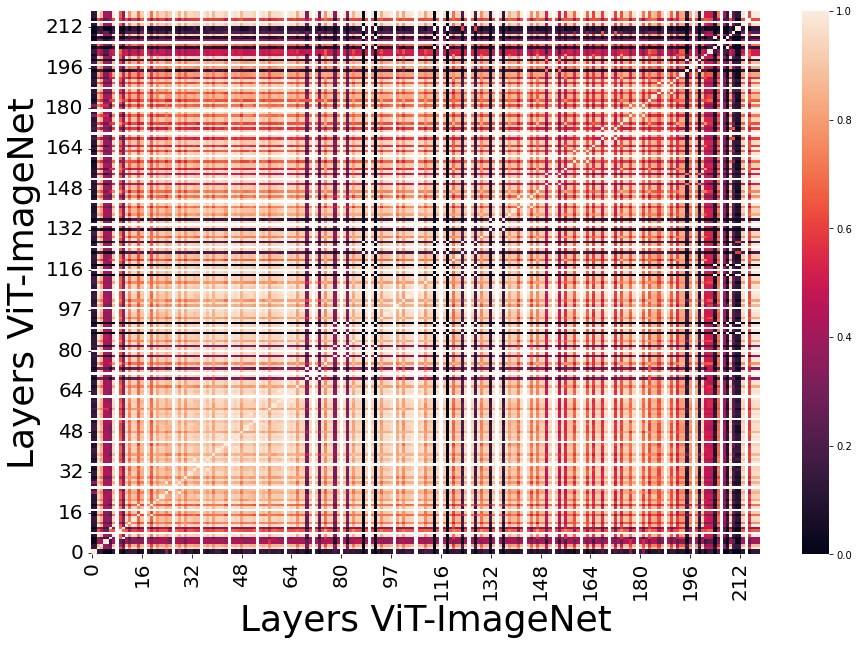

In [19]:
plt.figure(figsize=(15,10))
ax = sns.heatmap(hsicDataFrame.T)
plt.xlabel("Layers "+LABEL,fontsize='36')
plt.ylabel("Layers "+LABEL,fontsize='36')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xticks(ax.get_xticks()[::4])
ax.set_yticks(ax.get_yticks()[::4])
ax.invert_yaxis()
plt.savefig(LABEL+"_"+TYPE+'.pdf',fmt='pdf',bbox_inches='tight')